# Kriging 


In [17]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.colorbar import Colorbar
from matplotlib import ticker
import rasterio
from pykrige.ok import OrdinaryKriging
import geopandas as gpd
from shapely.geometry import box
from PIL import Image
import warnings
import matplotlib.cm as cm
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")

In [19]:
general_path = 'C:/Users/abner/OneDrive/Documentos/mestrado/DISSERTAÇÃO/scripts'
plt.rcParams.update({'font.family': 'Times New Roman'})
# Definindo os parâmetros
years = list(range(2014, 2025))
letra = list("abcdefghijklmnopqrstuvwxyz")
mapas =['EI_30', 'rain', 'E_D']
unity = ['Erosividade (MJ.mm/ha.h.ano)', 'Chuva anual (mm/ano)', 'Densidade de erosividade (MJ/ha.h)']
cmap_list = ['coolwarm_r', 'RdYlBu', 'viridis_r']
color_list=['#008B8B','#D35400','#4B4B4B']


# Ler o shapefile do Brasil
brasil_uf = gpd.read_file(r'C:\Users\abner\OneDrive\Documentos\mestrado\Telemetria-ANA\Shapefile\Brasil_UF\BR_UF_2022.shp')
brasil_shapefile = brasil_uf.to_crs('EPSG:4674')

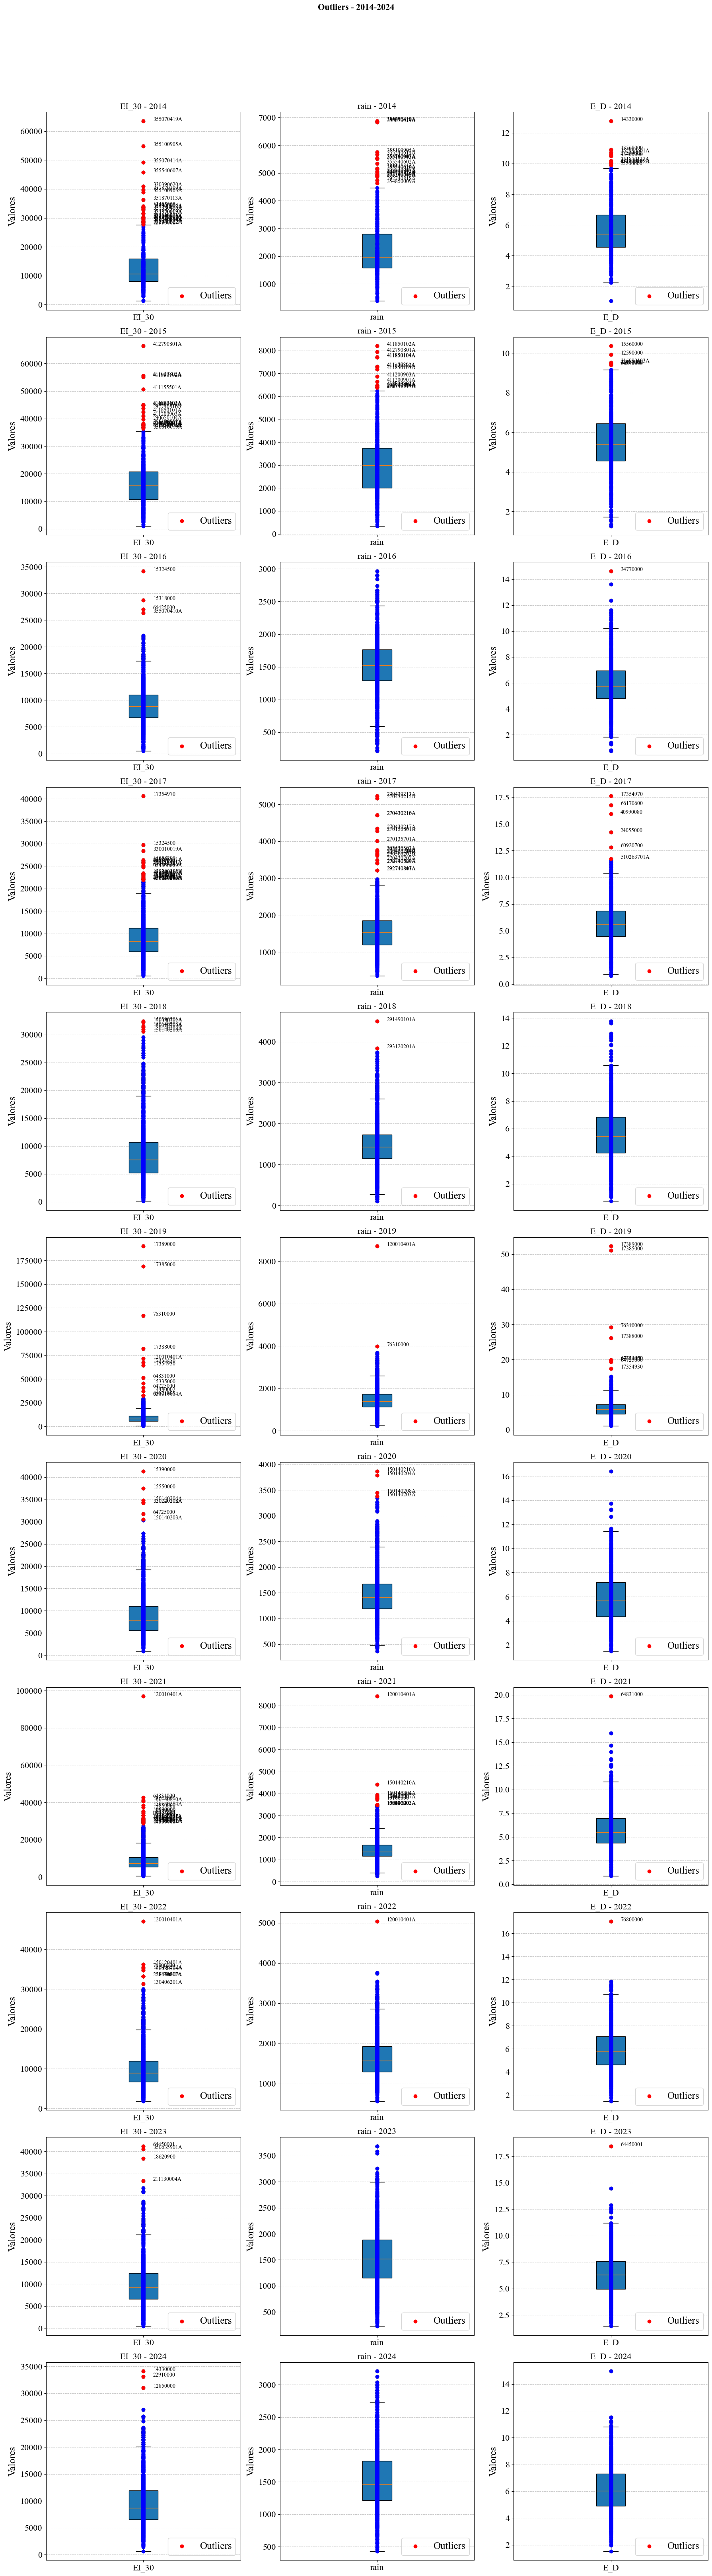

In [21]:

output_dir = os.path.join(general_path, "2 - Result_images")
os.makedirs(output_dir, exist_ok=True)  # Criar as pastas automaticamente se não existirem

# Criar a figura com 11 linhas e 3 colunas
fig, axs = plt.subplots(11, 3, figsize=(18, 66))  # 11 linhas e 3 colunas
axs = axs.flatten()  # Transformar em uma lista para iterar facilmente

# Iteração sobre os anos
index = 0
for year in years:

    outliers_tot = pd.DataFrame()
    # Carregar os dados para o ano específico
    df_data = pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='EI_30')
    df_data = df_data[['state', 'gauge_code', 'long', 'lat', str(year)]].replace(0, np.nan).dropna().reset_index(drop=True)
    df_data = df_data.rename(columns={str(year): 'EI_30'})
    df_data['E_D'] = pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='E_D')[[str(year)]].replace(0, np.nan).dropna().reset_index(drop=True)[str(year)]
    df_data['rain'] = df_data['EI_30'] / df_data['E_D']

    # Iteração sobre as colunas de interesse
    for i, coluna in enumerate(mapas):
        # Cálculo do IQR e limites para identificar os outliers
        q1 = df_data[coluna].quantile(0.25)
        q3 = df_data[coluna].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 3.5 * iqr
        
        if year in [2014, 2015]:
            upper_bound = q3 + 1.5 * iqr
        elif year == 2017:
            upper_bound = q3 + 2 * iqr
        else:
            upper_bound = q3 + 3.5 * iqr

        outliers = df_data[(df_data[coluna] < lower_bound) | (df_data[coluna] > upper_bound)]
        non_outliers = df_data[(df_data[coluna] >= lower_bound) & (df_data[coluna] <= upper_bound)]
        axs[index].boxplot(df_data[coluna], vert=True, patch_artist=True)
        axs[index].scatter([1] * len(non_outliers), non_outliers[coluna], color='blue', zorder=3)
        axs[index].scatter([1] * len(outliers), outliers[coluna], color='red', zorder=4, label='Outliers')

        for outlier_index, row in outliers.iterrows():
            axs[index].text(1.05, row[coluna], row['gauge_code'], fontsize=10, color='black')
        axs[index].set_title(f'{coluna} - {year}', fontsize=16)
        axs[index].set_ylabel('Valores', fontsize=18)
        axs[index].set_xticks([1])
        axs[index].set_xticklabels([coluna], fontsize=18)
        axs[index].tick_params(labelsize=16)
        axs[index].legend(loc='lower right', fontsize=18)
        axs[index].grid(True, axis='y', linestyle='--', alpha=0.7)
        index += 1
    outliers_tot = pd.concat([outliers_tot, outliers], ignore_index=True).drop_duplicates()  
    outliers_tot.to_hdf(os.path.join(general_path,'2 - Result_images', 'outliers_removidos.h5'),key=str(year), mode='a')
       
fig.suptitle(f"Outliers - {years[0]}-{years[-1]}", fontsize=16, fontweight='bold')


output_path_comparison = os.path.join(output_dir, f"outliers_comparacao_{years[0]}_{years[-1]}.png")
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta o espaço para o título principal
plt.savefig(output_path_comparison, dpi=300, bbox_inches='tight')
plt.show()



In [4]:
# df_outliers=pd.read_hdf(os.path.join(general_path,'2 - Result_images', 'outliers_removidos.h5'),key=str(2019))
# lista_outliers=df_outliers['gauge_code'].to_list()
# #FILTRO
# df_outliers.to_hdf(os.path.join(general_path,'2 - Result_images', 'outliers_removidos.h5'),key=str(year), mode='a')
# df_data=df_data[~df_data['gauge_code'].isin(lista_outliers)]

In [5]:
with pd.HDFStore(os.path.join(general_path,'outliers_removidos.h5')) as hdf:
    keys = hdf.keys()  # Obtém todas as chaves do arquivo HDF
    for key in keys:  # Itera por cada chave
        df = pd.read_hdf(hdf, key=key)  # Lê os dados de cada chave
        print(f"Chave: {key}, Número de linhas: {len(df)}")


Chave: /2014, Número de linhas: 4
Chave: /2015, Número de linhas: 9
Chave: /2016, Número de linhas: 2
Chave: /2017, Número de linhas: 0
Chave: /2018, Número de linhas: 0
Chave: /2019, Número de linhas: 13
Chave: /2020, Número de linhas: 2
Chave: /2021, Número de linhas: 2
Chave: /2022, Número de linhas: 2
Chave: /2023, Número de linhas: 0
Chave: /2024, Número de linhas: 5


In [6]:
with pd.HDFStore(os.path.join(general_path, '2 - Result_images', 'outliers_removidos.h5')) as hdf:
    keys = hdf.keys()  # Obtém todas as chaves do arquivo HDF
    for key in keys:  # Itera por cada chave
        df = pd.read_hdf(hdf, key=key)  # Lê os dados de cada chave
        print(f"Chave: {key}, Número de linhas: {len(df)}")

Chave: /2014, Número de linhas: 9
Chave: /2015, Número de linhas: 6
Chave: /2016, Número de linhas: 1
Chave: /2017, Número de linhas: 6
Chave: /2018, Número de linhas: 0
Chave: /2019, Número de linhas: 8
Chave: /2020, Número de linhas: 0
Chave: /2021, Número de linhas: 1
Chave: /2022, Número de linhas: 1
Chave: /2023, Número de linhas: 1
Chave: /2024, Número de linhas: 0


In [7]:
def custom_formatter(x, pos):
    if x >= 1e6:
        return f'{int(x*1e-6)} M'
    elif x >= 1e3:
        return f'{int(x*1e-3)} k'
    else:
        return f'{x:.1f}'

In [8]:
df= pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='EI_30')
# Selecionar apenas colunas correspondentes aos anos de 2014 a 2024
anos = [str(ano) for ano in range(2014, 2025)]
df_anos = df[anos]
valores = df_anos.values.flatten()
faixas = [
    (0.1, 2452, "Erosividade Fraca"),
    (2452, 4905, "Erosividade Média"),
    (4905, 7357, "Erosividade Média-Forte"),
    (7357, 9810, "Erosividade Forte"),
    (9810, None, "Erosividade Muito Forte")
]
tabela = []
valores = valores[valores != 0]
total_valores = len(valores)
for faixa in faixas:
    limite_inferior, limite_superior, descricao = faixa
    if limite_inferior is None:  # Sem limite inferior
        filtro = valores <= limite_superior
    elif limite_superior is None:  # Sem limite superior
        filtro = valores > limite_inferior
    else:  # Limite inferior e superior definidos
        filtro = (valores > limite_inferior) & (valores <= limite_superior)
    num_valores = filtro.sum()
    percentual_observado = (num_valores / total_valores) * 100 if total_valores > 0 else 0
    tabela.append({
        "Erosividade (R)": f"{limite_inferior if limite_inferior is not None else ''} < R ≤ {limite_superior if limite_superior is not None else ''}",
        "Nível de Erosividade": descricao,
        "Percentual Observado (%)": f"{percentual_observado:.1f}%",
        "Número de Estações (2014–2024)": num_valores
    })
df_tabela = pd.DataFrame(tabela)
df_tabela.to_excel(os.path.join(general_path, '2 - Result_images', 'classificação erosividade-observados.xlsx'))
df_tabela

Erosividade (R)     Nível de Erosividade Percentual Observado (%)  \
0   0.1 < R ≤ 2452        Erosividade Fraca                     3.0%   
1  2452 < R ≤ 4905        Erosividade Média                    12.3%   
2  4905 < R ≤ 7357  Erosividade Média-Forte                    22.9%   
3  7357 < R ≤ 9810        Erosividade Forte                    23.7%   
4      9810 < R ≤   Erosividade Muito Forte                    38.1%   

   Número de Estações (2014–2024)  
0                             473  
1                            1918  
2                            3563  
3                            3692  
4                            5938

In [13]:
#mapas individuais
plt.rcParams.update({'font.family': 'Times New Roman'})
output_dir = os.path.join(general_path, "2 - Result_images")
os.makedirs(output_dir, exist_ok=True)

for k, mapa in enumerate(mapas):
    cmap = cmap_list[k]
    for year in [2015]:  # Loop para os anos de 2014 a 2023
        df_data = pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='EI_30')
        df_data = df_data[['state', 'gauge_code', 'long', 'lat', str(year)]].replace(0, np.nan).dropna().reset_index(drop=True)
        df_data = df_data.rename(columns={str(year): 'EI_30'})
        df_data['E_D'] = pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='E_D')[[str(year)]].replace(0, np.nan).dropna().reset_index(drop=True)[str(year)]
        df_data['rain'] = df_data['EI_30'] / df_data['E_D']
    
        df_outliers = pd.read_hdf(os.path.join(general_path, 'outliers_removidos.h5'), key=str(year))
        if mapa == 'rain':df_outliers = pd.read_hdf(os.path.join(general_path,'outliers_removidos.h5'), key=str(year))
        lista_outliers = df_outliers['gauge_code'].to_list()
        df_data = df_data[~df_data['gauge_code'].isin(lista_outliers)]
    
        latitude = df_data['lat'].values
        longitude = df_data['long'].values
        aqi_value = df_data[mapa].values ### escolher aqui o mapa
    
        minx, miny, maxx, maxy = brasil_shapefile.total_bounds
        extent = [minx, maxx, miny, maxy]
        gridx = np.linspace(minx, maxx, 150)
        gridy = np.linspace(miny, maxy, 150)
    
        OK = OrdinaryKriging(
            longitude, latitude, aqi_value,
            variogram_model='spherical',
            coordinates_type='geographic',
            verbose=False,
            nlags=18
        )
    
        z_interp, ss = OK.execute('grid', gridx, gridy)
    
        variogram_parameters = OK.variogram_model_parameters
        # Calcular o grau de dependência espacial (SDD)
        C0 = variogram_parameters[0]  # Nugget
        C1 = variogram_parameters[2]  # Sill - Nugget
        SDD = (C0 / (C0 + C1)) * 100
        # Gerar o gráfico principal
        fig, ax_map = plt.subplots(figsize=(10, 10))
    
        # Exibir a interpolação no mapa principal
        cax = ax_map.imshow(
            z_interp,
            extent=extent,
            origin='lower',
            cmap=cmap,
            alpha=1,
        )
        brasil_shapefile.plot(ax=ax_map, facecolor="none", edgecolor="black", linewidth=1)
        ax_map.scatter(
            longitude, latitude,
            color="gray", label="Pontos utilizados",
            zorder=3, marker='o', s=14, edgecolor="black", linewidth=0.45,
        )
        ax_map.set_title(f"Interpolação Kriging Ordinário  {unity[k]} - {year}", fontsize=16)
        ax_map.grid(alpha=0.6)
        ax_map.legend(fontsize=13)
        ax_map.tick_params(labelsize=16)
    
        # Adicionar barra de cores ao mapa principal
        cbar = fig.colorbar(cax, ax=ax_map, orientation='vertical', fraction=0.036, shrink=0.4, pad=0.02)
        cbar.set_label(f'{unity[k]}', fontsize=15)
        cbar.ax.tick_params(labelsize=13)
        inset_ax = fig.add_axes([0.195, 0.215, 0.21, 0.2])
        lags = OK.lags
        semivariance = OK.semivariance
        variogram_model = OK.variogram_model
        variogram_parameters = OK.variogram_model_parameters
        model_values = OK.variogram_function(variogram_parameters, lags)
    
        inset_ax.plot(lags, semivariance, 'o', label='Semivariância', alpha=0.6)
        inset_ax.plot(lags, model_values, '-', label=f'Modelo {variogram_model}', alpha=1 ,color = color_list[k])
        inset_ax.set_title("Variograma", fontsize=15)
        inset_ax.set_xlabel("Distância (km)", fontsize=12)
        inset_ax.set_ylabel("Semivariância", fontsize=12)
        inset_ax.legend(fontsize=12, loc='upper left', frameon=False)
        inset_ax.tick_params(labelsize=11)
        inset_ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
        inset_ax.grid(alpha=0.7)
        inset_ax.set_facecolor((1, 1, 1, 0.4))  # Fundo transparente com RGBA
        # Adicionar o SDD no mapa principal
        sdd_text = f"SDD = {SDD:.2f}%"
        ax_map.text(0.8, 0.03, sdd_text, fontsize=16, color='black', transform=ax_map.transAxes,
                    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        
        # Salvar o mapa com o variograma
        output_dir = os.path.join(general_path, '2 - Result_images', str(year))
        os.makedirs(output_dir, exist_ok=True)
        output_path_map = os.path.join(output_dir, f"Krigagem_ordinária_{mapa}_{year}.png")
        plt.savefig(output_path_map, dpi=300, bbox_inches='tight')
    
        raster_path = os.path.join(output_dir, f"{mapa}_map_{year}.tif")
        with open(raster_path, 'wb') as f:
            Image.fromarray(z_interp).save(f)
        
        # Salvar apenas o variograma
        fig_variogram, ax_variogram = plt.subplots(figsize=(6, 6))
        ax_variogram.plot(lags, semivariance, 'o', label='Semivariância', alpha=0.7)
        ax_variogram.plot(lags, model_values, '-', label=f'Modelo {variogram_model}', alpha=1, color = color_list[k])
        ax_variogram.set_xlabel("Distância (km)", fontsize=20)
        ax_variogram.set_ylabel("Semivariância", fontsize=20)
        ax_variogram.legend(fontsize=16, loc='upper left', frameon=False)
        ax_variogram.tick_params(labelsize=16)
        ax_variogram.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
        ax_variogram.grid(alpha=1)
        # Adicionar o SDD ao título do variograma
        ax_variogram.text(0.6, 0.05, sdd_text, fontsize=18, color='black', transform=ax_variogram.transAxes,
                          bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        output_path_variogram = os.path.join(output_dir, f"Variograma_{year}_{mapa}.png")
        fig_variogram.savefig(output_path_variogram, dpi=300, bbox_inches='tight')
        plt.close(fig_variogram)
        plt.close(fig)


In [17]:
mapas[0]

'EI_30'

In [8]:
   #HISTOGRAMAS

for k, mapa in enumerate(mapas):
    for year in range(2014, 2025):
        df_data = pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='EI_30')
        df_data = df_data[['state', 'gauge_code', 'long', 'lat', str(year)]].replace(0, np.nan).dropna().reset_index(drop=True)
        df_data = df_data.rename(columns={str(year): 'EI_30'})
        df_data['E_D'] = pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='E_D')[[str(year)]].replace(0, np.nan).dropna().reset_index(drop=True)[str(year)]
        df_data['rain'] = df_data['EI_30'] / df_data['E_D']
    
        df_outliers = pd.read_hdf(os.path.join(general_path, '2 - Result_images', 'outliers_removidos.h5'), key=str(year))
        lista_outliers = df_outliers['gauge_code'].to_list()
        df_data = df_data[~df_data['gauge_code'].isin(lista_outliers)]
    
        latitude = df_data['lat'].values
        longitude = df_data['long'].values
        aqi_value = df_data[mapa].values
        # Filtrar valores menores que 30.000
        aqi_value = aqi_value[aqi_value < 30000]
    
        # Salvar o mapa com o variograma
        output_dir = os.path.join(general_path, '2 - Result_images', str(year))
        os.makedirs(output_dir, exist_ok=True)
        
        # Gerar e salvar o gráfico de histograma
        plt.figure(figsize=(8, 6))
        plt.hist(aqi_value, bins=20, color=color_list[k], edgecolor='black', alpha=0.7)
        plt.xlabel(f'{unity[k]}', fontsize=22)      
        plt.ylabel('Frequência', fontsize=22)
        plt.grid(True, linestyle='--', alpha=0.9)
        plt.gca().tick_params(labelsize=20)
        plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
        
        # Salvar histograma
        output_path_histogram = os.path.join(output_dir, f"Histograma_{year}_{mapa}.png")
        plt.savefig(output_path_histogram, dpi=300, bbox_inches='tight')
        plt.close()  # Fechar a figura para liberar memória

In [4]:
cmap_list

['coolwarm_r', 'RdYlBu', 'viridis_r']

In [7]:
mapas

['EI_30', 'rain', 'E_D']

In [14]:
#all RASTERS ALL YEARS
plt.rcParams.update({'font.family': 'Times New Roman'})
for k, mapa in enumerate(mapas):


    
    bounds = brasil_shapefile.total_bounds
    minx, miny, maxx, maxy = bounds
    extent = [minx, maxx, miny, maxy]
    gridx = np.linspace(minx, maxx, 150)
    gridy = np.linspace(miny, maxy, 150)
    z_min, z_max = float('inf'), float('-inf')
    cmap = cmap_list[k]
    nrows, ncols = 3, 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12), constrained_layout=True)
    # Processamento dos anos
    for i, year in enumerate(years):

        df_data = pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='EI_30')
        df_data = df_data[['state', 'gauge_code', 'long', 'lat', str(year)]].replace(0, np.nan).dropna().reset_index(drop=True)
        df_data = df_data.rename(columns={str(year): 'EI_30'})
        df_data['E_D'] = pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='E_D')[[str(year)]].replace(0, np.nan).dropna().reset_index(drop=True)[str(year)]
        df_data['rain'] = df_data['EI_30'] / df_data['E_D']
    
        df_outliers = pd.read_hdf(os.path.join(general_path, '2 - Result_images', 'outliers_removidos.h5'), key=str(year))
        lista_outliers = df_outliers['gauge_code'].to_list()
        df_data = df_data[~df_data['gauge_code'].isin(lista_outliers)]
    
        latitude = df_data['lat'].values
        longitude = df_data['long'].values
        aqi_value = df_data[mapa].values

        output_dir = os.path.join(general_path, '2 - Result_images', 'Results-dissertação',str(year))
        if mapa == 'rain':output_dir = os.path.join(general_path, '2 - Result_images',str(year))
        raster_path = os.path.join(output_dir, f"{mapa}_map_{year}.tif")
        with rasterio.open(raster_path) as f:
            z_interp = f.read(1)


        if mapa == 'EI_30':
            z_interp = np.where(z_interp > 31000, 31000, z_interp)  # Define o limite máximo
        if mapa == 'rain':
            z_interp = np.where(z_interp > 3500, 3500, z_interp)  # Define o limite máximo

        z_min = min(z_min, z_interp.min())
        z_max = max(z_max, z_interp.max())

        ax = axes[i // ncols, i % ncols]
        im = ax.imshow(z_interp, extent=extent, origin='lower', cmap=cmap, alpha=1, vmin=None, vmax=None)
        brasil_shapefile.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)
        ax.scatter(longitude, latitude, color="k", zorder=3, marker='o', s=4)
        ax.set_title(f"{letra[i]})  {year}", fontsize=20)
        ax.set_xlim([minx, maxx])
        ax.set_ylim([miny, maxy])
        ax.grid(color='gray', linestyle='--', linewidth=0.5)
        ax.set_aspect('equal', 'box')
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1)
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Remove os números das bordas
    for ax in axes.flat:
        im.set_clim(z_min, z_max)
    axes[-1, -1].axis("off")
    pos = axes[-1, -1].get_position()  # Posição do último subplot
    cbar_ax = fig.add_axes([pos.x0+0.1, pos.y0, 0.03 , pos.height-0.03])  # Usa a mesma posição e tamanho
    norm = cm.colors.Normalize(vmin=z_min, vmax=z_max)
    cbar = Colorbar(ax=cbar_ax, mappable=cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical')
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label(unity[k], fontsize=18)
    plt.savefig(general_path + r'\2 - Result_images\Krigagem_ordinária_'+mapa+'_All_years', dpi=300, bbox_inches='tight')
    plt.close()

In [9]:
pos.height

0.24022527777777777

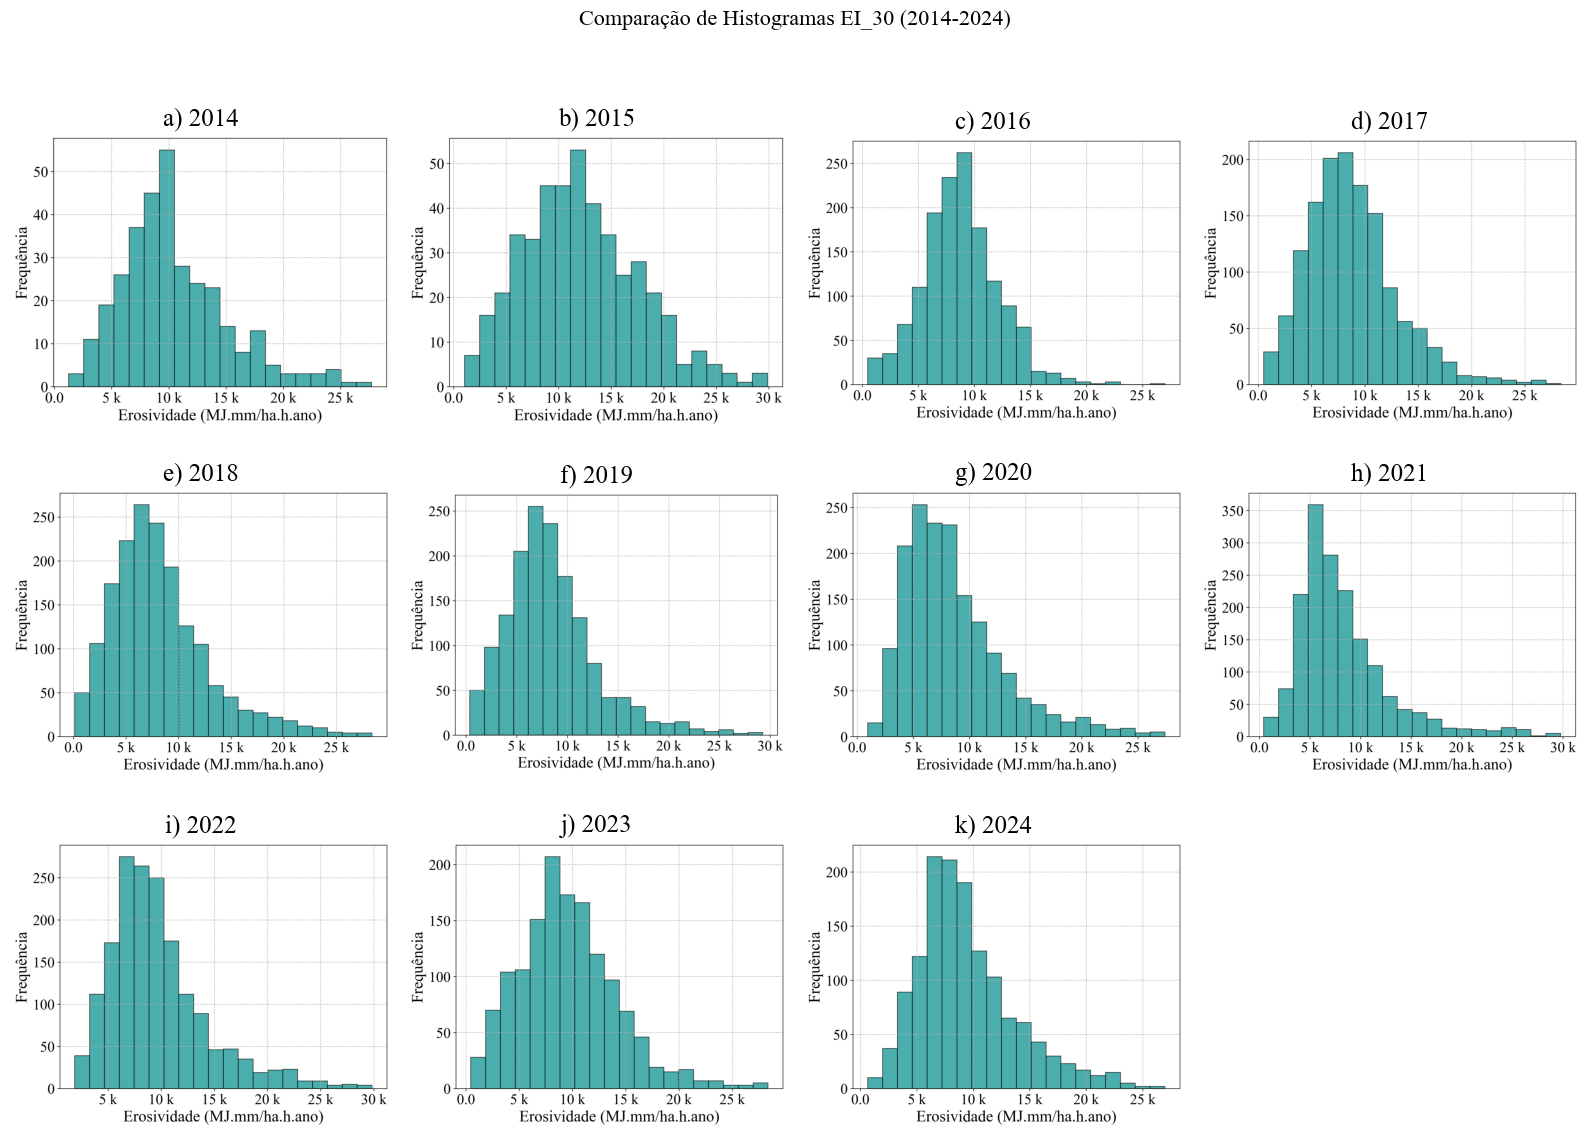

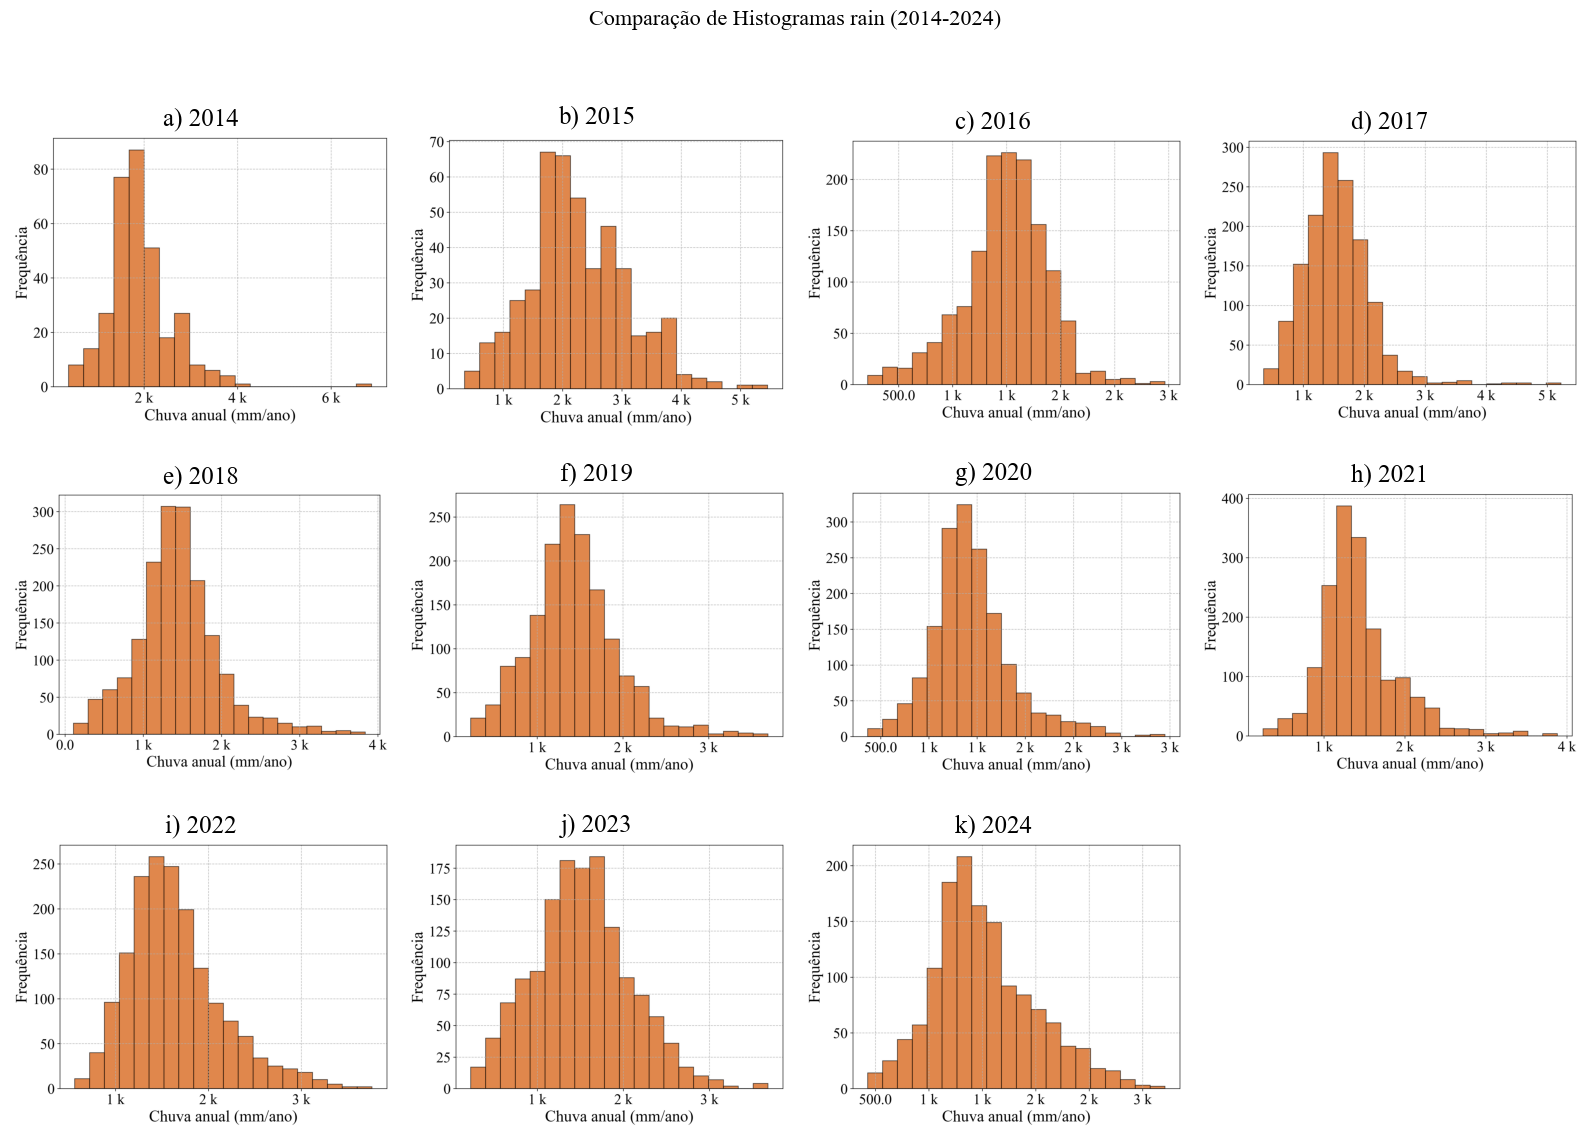

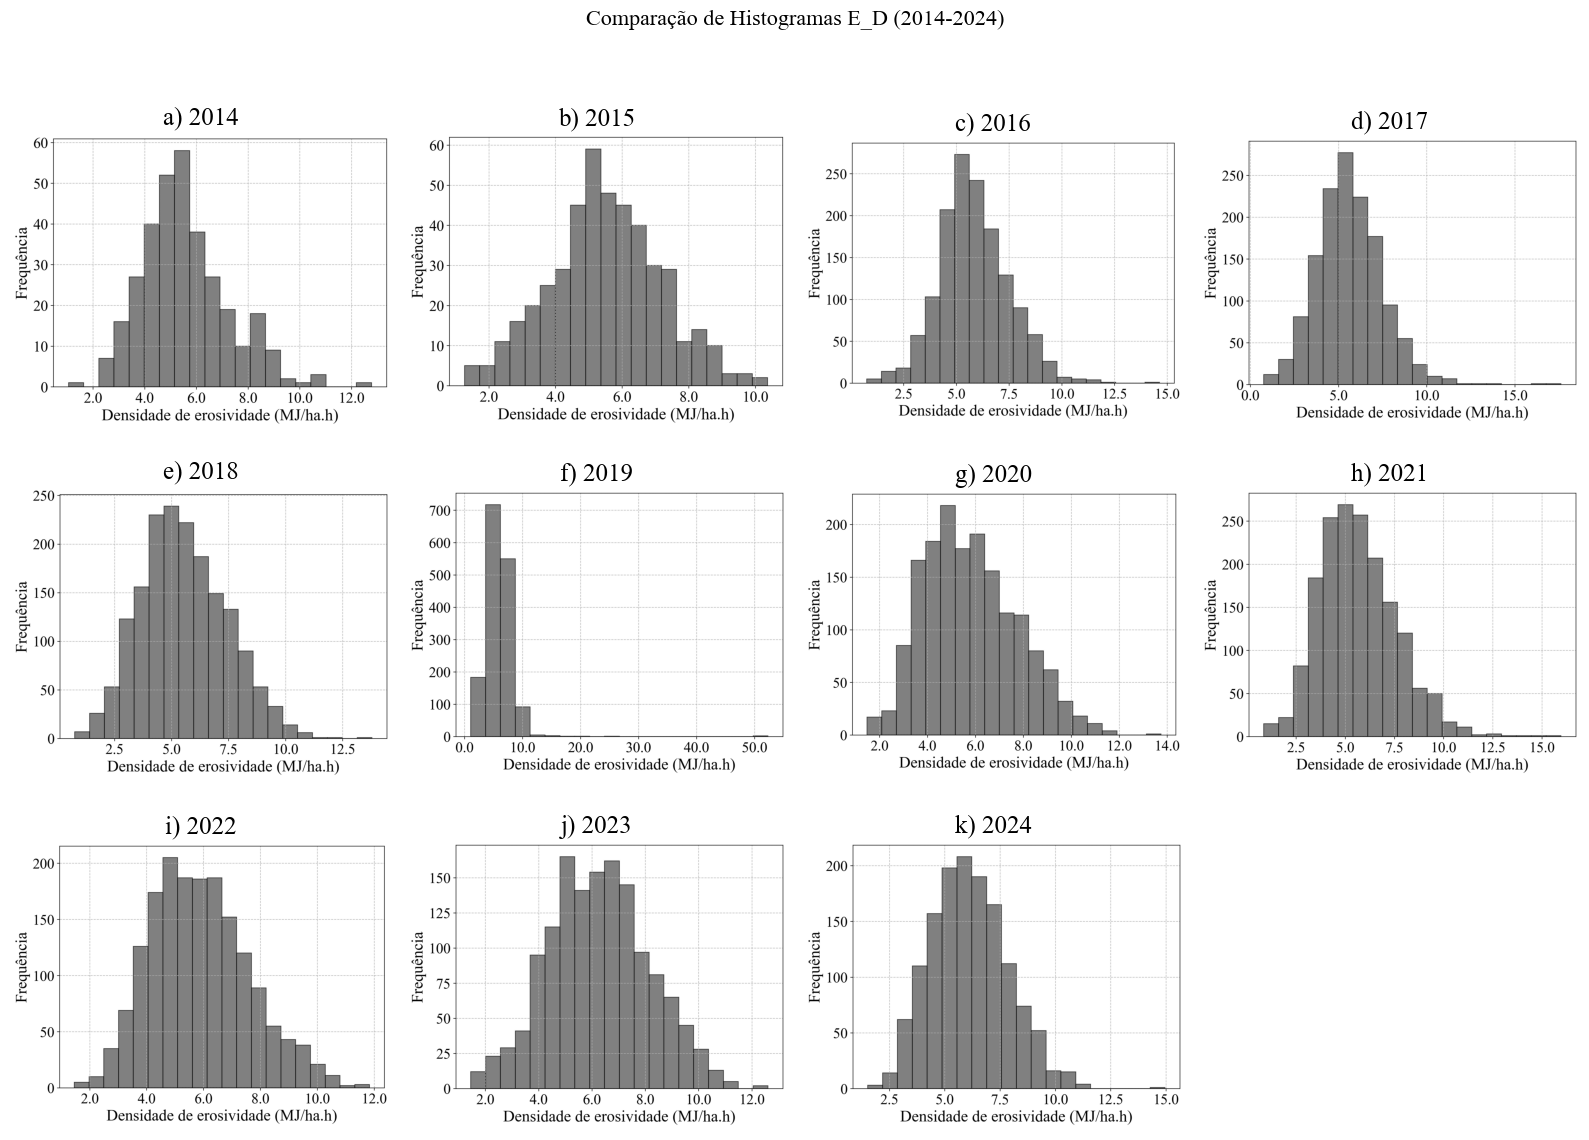

In [5]:
#HISTOGRAM COLLECTION
# Definindo a fonte global para Times New Roman
plt.rcParams.update({'font.family': 'Times New Roman'})
input_dir = os.path.join(general_path, '2 - Result_images')

for mapa in mapas:
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))  # 4 colunas e 3 linhas
    axes = axes.flatten()

    
    for i, year in enumerate(years):
        ax = axes[i]
        file_path = os.path.join(input_dir, str(year), f"Histograma_{year}_{mapa}.png")
        
        if os.path.exists(file_path):
            ax.imshow(Image.open(file_path))
            ax.set_title(f"{letra[i]}) {year}", fontsize=18)
        else:
            ax.set_title(f"{year} (Faltando)", fontsize=12, color='red')
        
        ax.axis('off')

    # Excluindo eixos extras caso o número de anos seja menor que 12
    for ax in axes[len(years):]:
        fig.delaxes(ax)

    # Título geral para o conjunto de mapas
    fig.suptitle(f"Comparação de Histogramas {mapa} (2014-2024)", fontsize=16)

    # Ajustando layout para evitar sobreposição
    fig.tight_layout(rect=[0, 0, 1, 0.95])

    # Salvando o gráfico para cada mapa separadamente
    plt.savefig(os.path.join(input_dir, f"Comparacao_Histogramas_{mapa}_2014_2024.png"), dpi=300, bbox_inches='tight')
    plt.show()





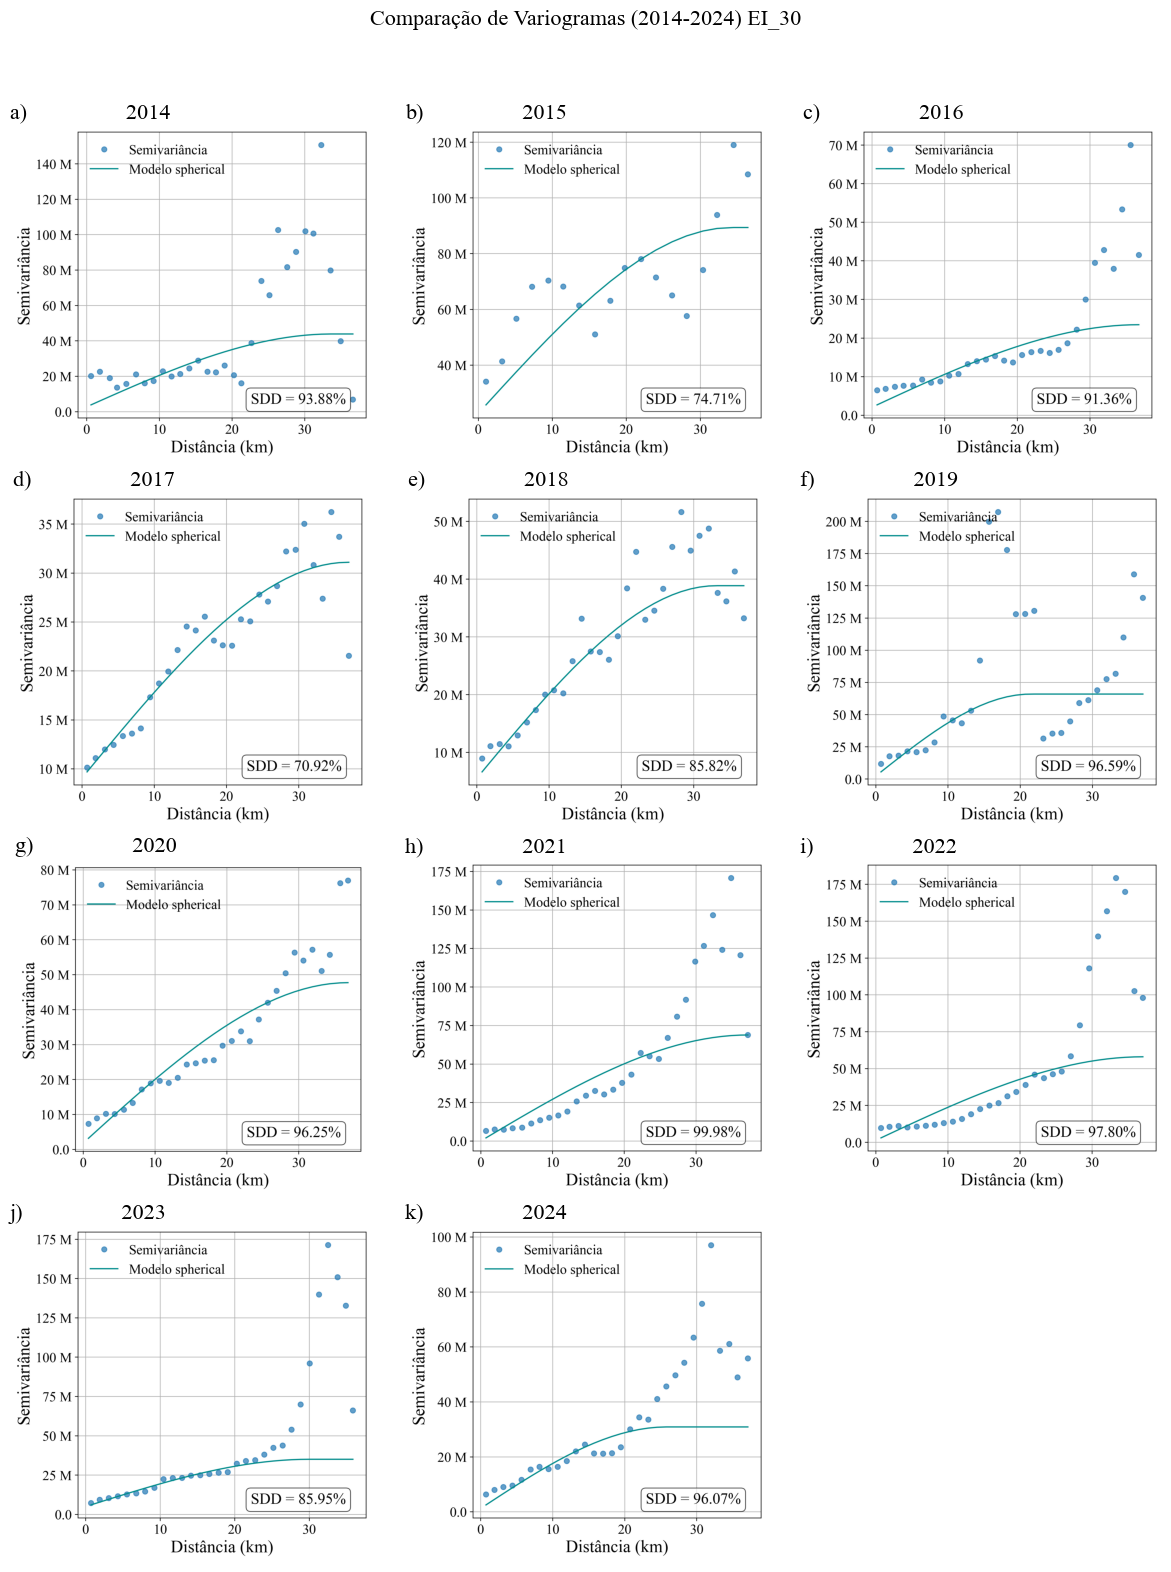

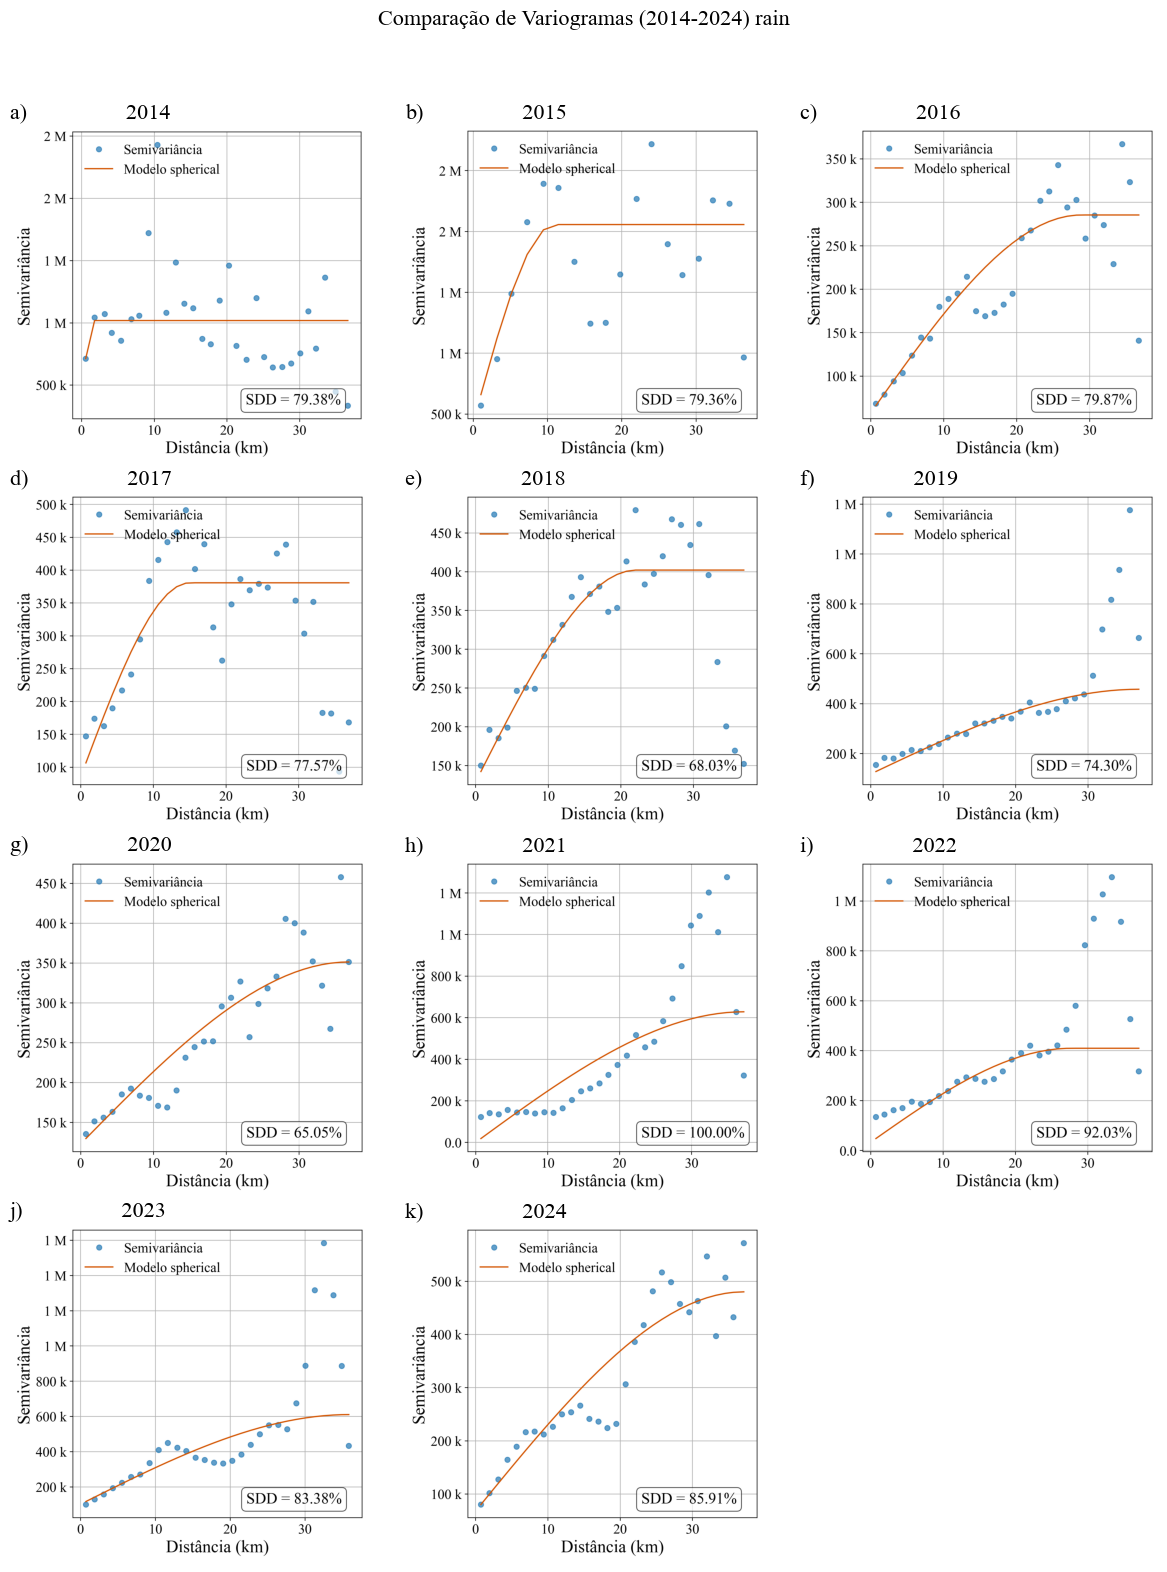

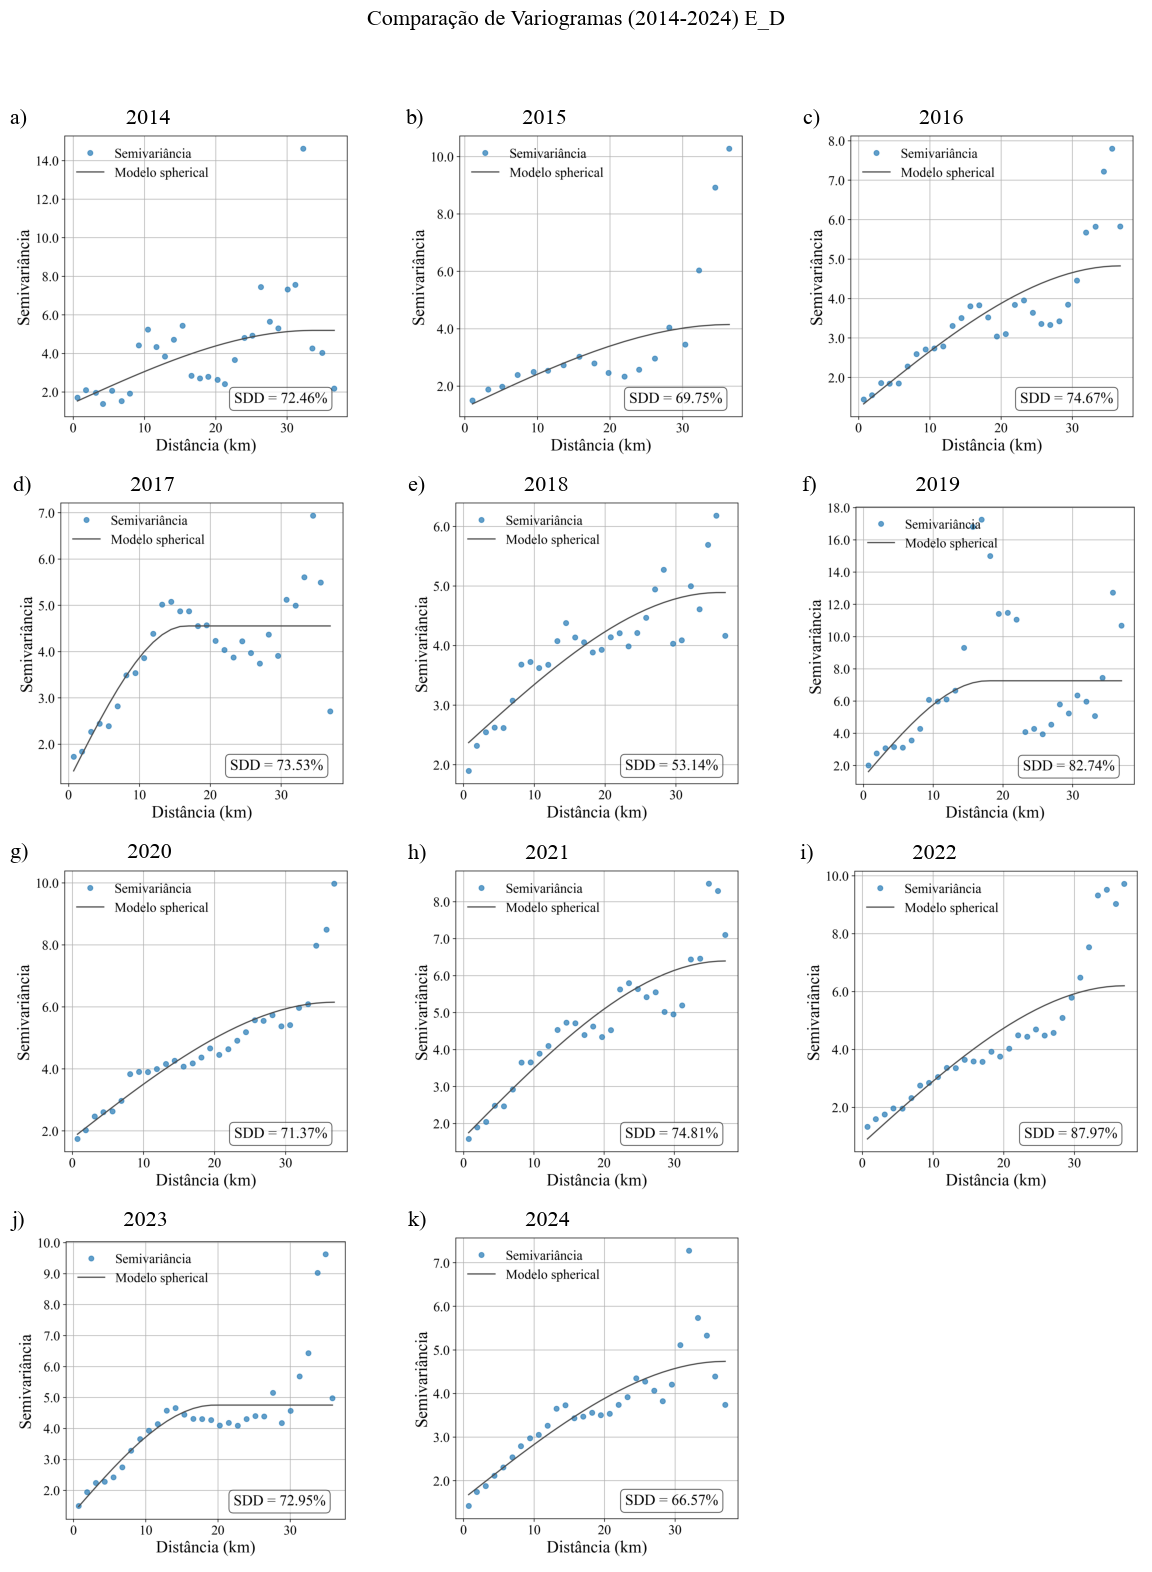

In [9]:
## VARIOGRAM COLLECTION
for mapa in mapas:
    # Configurações do diretório de entrada e anos
    input_dir = os.path.join(general_path, '2 - Result_images')
      # Anos de 2014 a 2023
    years = list(range(2014, 2025))
    # Criar o subplot
    fig, axes = plt.subplots(4, 3, figsize=(12, 16))  
    axes = axes.flatten()  # Transformar em uma lista para iterar facilmente
    
    for i, year in enumerate(years):
        ax = axes[i]
        file_path = os.path.join(input_dir, str(year), f"Variograma_{year}_{mapa}.png")
        
        if os.path.exists(file_path):
            img = Image.open(file_path)
            ax.imshow(img)
            ax.set_title(f"{letra[i]})                  {year}", fontsize=16,loc='left')
            ax.axis('off')  # Esconder os eixos
        else:
            ax.set_title(f"{year} (Faltando)", fontsize=12, color='red')
            ax.axis('off')
    for ax in axes[len(years):]:
        fig.delaxes(ax)
    # Ajustar o layout
    fig.suptitle(f"Comparação de Variogramas (2014-2024) {mapa}", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Salvar e exibir o gráfico
    output_path_comparison = os.path.join(input_dir, f"Comparacao_Variogramas_{mapa}_2014_2024.png")
    plt.savefig(output_path_comparison, dpi=300, bbox_inches='tight')
    plt.show()


In [ ]:
###INGLES

In [10]:
# Individual maps
plt.rcParams.update({'font.family': 'Times New Roman'})
output_dir = os.path.join(general_path, "2 - Result_images", 'presentation')
os.makedirs(output_dir, exist_ok=True)

for k, mapa in enumerate(mapas):
    cmap = cmap_list[k]
    for year in years:  # Loop for the years from 2014 to 2023
        df_data = pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='EI_30')
        df_data = df_data[['state', 'gauge_code', 'long', 'lat', str(year)]].replace(0, np.nan).dropna().reset_index(drop=True)
        df_data = df_data.rename(columns={str(year): 'EI_30'})
        df_data['E_D'] = pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='E_D')[[str(year)]].replace(0, np.nan).dropna().reset_index(drop=True)[str(year)]
        df_data['rain'] = df_data['EI_30'] / df_data['E_D']
    
        df_outliers = pd.read_hdf(os.path.join(general_path, '2 - Result_images', 'outliers_removidos.h5'), key=str(year))
        if mapa == 'rain':
            df_outliers = pd.read_hdf(os.path.join(general_path, 'outliers_removidos.h5'), key=str(year))
        outlier_list = df_outliers['gauge_code'].to_list()
        df_data = df_data[~df_data['gauge_code'].isin(outlier_list)]
    
        latitude = df_data['lat'].values
        longitude = df_data['long'].values
        aqi_value = df_data[mapa].values  # Choose the map here
    
        minx, miny, maxx, maxy = brasil_shapefile.total_bounds
        extent = [minx, maxx, miny, maxy]
        gridx = np.linspace(minx, maxx, 150)
        gridy = np.linspace(miny, maxy, 150)
    
        OK = OrdinaryKriging(
            longitude, latitude, aqi_value,
            variogram_model='spherical',
            coordinates_type='geographic',
            verbose=False
        )
    
        z_interp, ss = OK.execute('grid', gridx, gridy)
    
        variogram_parameters = OK.variogram_model_parameters
        # Calculate the spatial dependence degree (SDD)
        C0 = variogram_parameters[0]  # Nugget
        C1 = variogram_parameters[2]  # Sill - Nugget
        SDD = (C0 / (C0 + C1)) * 100
        # Generate the main plot
        fig, ax_map = plt.subplots(figsize=(10, 10))
    
        # Display the interpolation on the main map
        cax = ax_map.imshow(
            z_interp,
            extent=extent,
            origin='lower',
            cmap=cmap,
            alpha=1,
        )
        brasil_shapefile.plot(ax=ax_map, facecolor="none", edgecolor="black", linewidth=1)
        ax_map.scatter(
            longitude, latitude,
            color="gray", label="Used points",
            zorder=3, marker='o', s=14, edgecolor="black", linewidth=0.45,
        )
        ax_map.set_title(f"Ordinary Kriging Interpolation {unity[k]} - {year}", fontsize=16)
        ax_map.grid(alpha=0.6)
        ax_map.legend(fontsize=13)
        ax_map.tick_params(labelsize=16)
    
        # Add color bar to the main map
        cbar = fig.colorbar(cax, ax=ax_map, orientation='vertical', fraction=0.036, shrink=0.4, pad=0.02)
        cbar.set_label(f'{unity[k]}', fontsize=15)
        cbar.ax.tick_params(labelsize=13)
        inset_ax = fig.add_axes([0.195, 0.215, 0.21, 0.2])
        lags = OK.lags
        semivariance = OK.semivariance
        variogram_model = OK.variogram_model
        variogram_parameters = OK.variogram_model_parameters
        model_values = OK.variogram_function(variogram_parameters, lags)
    
        inset_ax.plot(lags, semivariance, 'o', label='Semivariance', alpha=0.6)
        inset_ax.plot(lags, model_values, '-', label=f'Model {variogram_model}', alpha=1, color=color_list[k])
        inset_ax.set_title("Variogram", fontsize=15)
        inset_ax.set_xlabel("Distance (km)", fontsize=12)
        inset_ax.set_ylabel("Semivariance", fontsize=12)
        inset_ax.legend(fontsize=12, loc='upper left', frameon=False)
        inset_ax.tick_params(labelsize=11)
        inset_ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
        inset_ax.grid(alpha=0.7)
        inset_ax.set_facecolor((1, 1, 1, 0.4))  # Transparent background with RGBA
    
        # Add SDD to the main map
        sdd_text = f"SDD = {SDD:.2f}%"
        ax_map.text(0.8, 0.03, sdd_text, fontsize=16, color='black', transform=ax_map.transAxes,
                    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        
        # Save the map with the variogram
        output_dir = os.path.join(general_path, '2 - Result_images', 'presentation', str(year))
        os.makedirs(output_dir, exist_ok=True)
        output_path_map = os.path.join(output_dir, f"Ordinary_Kriging_{mapa}_{year}.png")
        plt.savefig(output_path_map, dpi=300, bbox_inches='tight')
    
        raster_path = os.path.join(output_dir, f"{mapa}_map_{year}.tif")
        with open(raster_path, 'wb') as f:
            Image.fromarray(z_interp).save(f)
        
        # Save only the variogram
        fig_variogram, ax_variogram = plt.subplots(figsize=(6, 6))
        ax_variogram.plot(lags, semivariance, 'o', label='Semivariance', alpha=0.7)
        ax_variogram.plot(lags, model_values, '-', label=f'Model {variogram_model}', alpha=1, color=color_list[k])
        ax_variogram.set_xlabel("Distance (km)", fontsize=20)
        ax_variogram.set_ylabel("Semivariance", fontsize=20)
        ax_variogram.legend(fontsize=16, loc='upper left', frameon=False)
        ax_variogram.tick_params(labelsize=16)
        ax_variogram.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
        ax_variogram.grid(alpha=1)
        # Add SDD to the variogram title
        ax_variogram.text(0.6, 0.05, sdd_text, fontsize=18, color='black', transform=ax_variogram.transAxes,
                          bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        output_path_variogram = os.path.join(output_dir, f"Variogram_{year}_{mapa}.png")
        fig_variogram.savefig(output_path_variogram, dpi=300, bbox_inches='tight')
        plt.close(fig_variogram)
        plt.close(fig)


In [10]:
# Individual maps
plt.rcParams.update({'font.family': 'Times New Roman'})
output_dir = os.path.join(general_path, "2 - Result_images", 'presentation')
os.makedirs(output_dir, exist_ok=True)

for k, mapa in enumerate(mapas):
    cmap = cmap_list[k]
    for year in years:  # Loop for the years from 2014 to 2023
        df_data = pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='EI_30')
        df_data = df_data[['state', 'gauge_code', 'long', 'lat', str(year)]].replace(0, np.nan).dropna().reset_index(drop=True)
        df_data = df_data.rename(columns={str(year): 'EI_30'})
        df_data['E_D'] = pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='E_D')[[str(year)]].replace(0, np.nan).dropna().reset_index(drop=True)[str(year)]
        df_data['rain'] = df_data['EI_30'] / df_data['E_D']
    
        df_outliers = pd.read_hdf(os.path.join(general_path, '2 - Result_images', 'outliers_removidos.h5'), key=str(year))
        if mapa == 'rain':
            df_outliers = pd.read_hdf(os.path.join(general_path, 'outliers_removidos.h5'), key=str(year))
        outlier_list = df_outliers['gauge_code'].to_list()
        df_data = df_data[~df_data['gauge_code'].isin(outlier_list)]
    
        latitude = df_data['lat'].values
        longitude = df_data['long'].values
        aqi_value = df_data[mapa].values  # Choose the map here
    
        minx, miny, maxx, maxy = brasil_shapefile.total_bounds
        extent = [minx, maxx, miny, maxy]
        gridx = np.linspace(minx, maxx, 150)
        gridy = np.linspace(miny, maxy, 150)
    
        OK = OrdinaryKriging(
            longitude, latitude, aqi_value,
            variogram_model='spherical',
            coordinates_type='geographic',
            verbose=False
        )
    
        z_interp, ss = OK.execute('grid', gridx, gridy)
    
        variogram_parameters = OK.variogram_model_parameters
        # Calculate the spatial dependence degree (SDD)
        C0 = variogram_parameters[0]  # Nugget
        C1 = variogram_parameters[2]  # Sill - Nugget
        SDD = (C0 / (C0 + C1)) * 100
        # Generate the main plot
        fig, ax_map = plt.subplots(figsize=(10, 10))
    
        # Display the interpolation on the main map
        cax = ax_map.imshow(
            z_interp,
            extent=extent,
            origin='lower',
            cmap=cmap,
            alpha=1,
        )
        brasil_shapefile.plot(ax=ax_map, facecolor="none", edgecolor="black", linewidth=1)
        ax_map.scatter(
            longitude, latitude,
            color="gray", label="Used points",
            zorder=3, marker='o', s=14, edgecolor="black", linewidth=0.45,
        )
        ax_map.set_title(f"Ordinary Kriging Interpolation {unity[k]} - {year}", fontsize=16)
        ax_map.grid(alpha=0.6)
        ax_map.legend(fontsize=13)
        ax_map.tick_params(labelsize=16)
    
        # Add color bar to the main map
        cbar = fig.colorbar(cax, ax=ax_map, orientation='vertical', fraction=0.036, shrink=0.4, pad=0.02)
        cbar.set_label(f'{unity[k]}', fontsize=15)
        cbar.ax.tick_params(labelsize=13)
        inset_ax = fig.add_axes([0.195, 0.215, 0.21, 0.2])
        lags = OK.lags
        semivariance = OK.semivariance
        variogram_model = OK.variogram_model
        variogram_parameters = OK.variogram_model_parameters
        model_values = OK.variogram_function(variogram_parameters, lags)
    
        inset_ax.plot(lags, semivariance, 'o', label='Semivariance', alpha=0.6)
        inset_ax.plot(lags, model_values, '-', label=f'Model {variogram_model}', alpha=1, color=color_list[k])
        inset_ax.set_title("Variogram", fontsize=15)
        inset_ax.set_xlabel("Distance (km)", fontsize=12)
        inset_ax.set_ylabel("Semivariance", fontsize=12)
        inset_ax.legend(fontsize=12, loc='upper left', frameon=False)
        inset_ax.tick_params(labelsize=11)
        inset_ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
        inset_ax.grid(alpha=0.7)
        inset_ax.set_facecolor((1, 1, 1, 0.4))  # Transparent background with RGBA
    
        # Add SDD to the main map
        sdd_text = f"SDD = {SDD:.2f}%"
        ax_map.text(0.8, 0.03, sdd_text, fontsize=16, color='black', transform=ax_map.transAxes,
                    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        
        # Save the map with the variogram
        output_dir = os.path.join(general_path, '2 - Result_images', 'presentation', str(year))
        os.makedirs(output_dir, exist_ok=True)
        output_path_map = os.path.join(output_dir, f"Ordinary_Kriging_{mapa}_{year}.png")
        plt.savefig(output_path_map, dpi=300, bbox_inches='tight')
    
        raster_path = os.path.join(output_dir, f"{mapa}_map_{year}.tif")
        with open(raster_path, 'wb') as f:
            Image.fromarray(z_interp).save(f)
        
        # Save only the variogram
        fig_variogram, ax_variogram = plt.subplots(figsize=(6, 6))
        ax_variogram.plot(lags, semivariance, 'o', label='Semivariance', alpha=0.7)
        ax_variogram.plot(lags, model_values, '-', label=f'Model {variogram_model}', alpha=1, color=color_list[k])
        ax_variogram.set_xlabel("Distance (km)", fontsize=20)
        ax_variogram.set_ylabel("Semivariance", fontsize=20)
        ax_variogram.legend(fontsize=16, loc='upper left', frameon=False)
        ax_variogram.tick_params(labelsize=16)
        ax_variogram.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
        ax_variogram.grid(alpha=1)
        # Add SDD to the variogram title
        ax_variogram.text(0.6, 0.05, sdd_text, fontsize=18, color='black', transform=ax_variogram.transAxes,
                          bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        output_path_variogram = os.path.join(output_dir, f"Variogram_{year}_{mapa}.png")
        fig_variogram.savefig(output_path_variogram, dpi=300, bbox_inches='tight')
        plt.close(fig_variogram)
        plt.close(fig)


In [7]:
# Individual maps
plt.rcParams.update({'font.family': 'Times New Roman'})
output_dir = os.path.join(general_path, "2 - Result_images", 'presentation')
os.makedirs(output_dir, exist_ok=True)

for k, mapa in enumerate(mapas):
    cmap = cmap_list[k]
    for year in years:  # Loop for the years from 2014 to 2023
        df_data = pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='EI_30')
        df_data = df_data[['state', 'gauge_code', 'long', 'lat', str(year)]].replace(0, np.nan).dropna().reset_index(drop=True)
        df_data = df_data.rename(columns={str(year): 'EI_30'})
        df_data['E_D'] = pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='E_D')[[str(year)]].replace(0, np.nan).dropna().reset_index(drop=True)[str(year)]
        df_data['rain'] = df_data['EI_30'] / df_data['E_D']
    
        df_outliers = pd.read_hdf(os.path.join(general_path, '2 - Result_images', 'outliers_removidos.h5'), key=str(year))
        if mapa == 'rain':
            df_outliers = pd.read_hdf(os.path.join(general_path, 'outliers_removidos.h5'), key=str(year))
        outlier_list = df_outliers['gauge_code'].to_list()
        df_data = df_data[~df_data['gauge_code'].isin(outlier_list)]
    
        latitude = df_data['lat'].values
        longitude = df_data['long'].values
        aqi_value = df_data[mapa].values  # Choose the map here
    
        minx, miny, maxx, maxy = brasil_shapefile.total_bounds
        extent = [minx, maxx, miny, maxy]
        gridx = np.linspace(minx, maxx, 150)
        gridy = np.linspace(miny, maxy, 150)
    
        OK = OrdinaryKriging(
            longitude, latitude, aqi_value,
            variogram_model='spherical',
            coordinates_type='geographic',
            verbose=False,
            nlags=60
        )
    
        z_interp, ss = OK.execute('grid', gridx, gridy)
    
        variogram_parameters = OK.variogram_model_parameters
        # Calculate the spatial dependence degree (SDD)
        C0 = variogram_parameters[0]  # Nugget
        C1 = variogram_parameters[2]  # Sill - Nugget
        SDD = (C0 / (C0 + C1)) * 100
        # Generate the main plot
        fig, ax_map = plt.subplots(figsize=(10, 10))
    
        # Display the interpolation on the main map
        cax = ax_map.imshow(
            z_interp,
            extent=extent,
            origin='lower',
            cmap=cmap,
            alpha=1,
        )
        brasil_shapefile.plot(ax=ax_map, facecolor="none", edgecolor="black", linewidth=1)
        ax_map.scatter(
            longitude, latitude,
            color="gray", label="Used points",
            zorder=3, marker='o', s=14, edgecolor="black", linewidth=0.45,
        )
        ax_map.set_title(f"Ordinary Kriging Interpolation {unity[k]} - {year}", fontsize=16)
        ax_map.grid(alpha=0.6)
        ax_map.legend(fontsize=13)
        ax_map.tick_params(labelsize=16)
    
        # Add color bar to the main map
        cbar = fig.colorbar(cax, ax=ax_map, orientation='vertical', fraction=0.036, shrink=0.4, pad=0.02)
        cbar.set_label(f'{unity[k]}', fontsize=15)
        cbar.ax.tick_params(labelsize=13)
        inset_ax = fig.add_axes([0.195, 0.215, 0.21, 0.2])
        lags = OK.lags
        semivariance = OK.semivariance
        variogram_model = OK.variogram_model
        variogram_parameters = OK.variogram_model_parameters
        model_values = OK.variogram_function(variogram_parameters, lags)
    
        inset_ax.plot(lags, semivariance, 'o', label='Semivariance', alpha=0.6)
        inset_ax.plot(lags, model_values, '-', label=f'Model {variogram_model}', alpha=1, color=color_list[k])
        inset_ax.set_title("Variogram", fontsize=15)
        inset_ax.set_xlabel("Distance (km)", fontsize=12)
        inset_ax.set_ylabel("Semivariance", fontsize=12)
        inset_ax.legend(fontsize=12, loc='upper left', frameon=False)
        inset_ax.tick_params(labelsize=11)
        inset_ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
        inset_ax.grid(alpha=0.7)
        inset_ax.set_facecolor((1, 1, 1, 0.4))  # Transparent background with RGBA
    
        # Add SDD to the main map
        sdd_text = f"SDD = {SDD:.2f}%"
        ax_map.text(0.8, 0.03, sdd_text, fontsize=16, color='black', transform=ax_map.transAxes,
                    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        
        # Save the map with the variogram
        output_dir = os.path.join(general_path, '2 - Result_images', 'presentation', str(year))
        os.makedirs(output_dir, exist_ok=True)
        output_path_map = os.path.join(output_dir, f"Ordinary_Kriging_{mapa}_{year}.png")
        plt.savefig(output_path_map, dpi=300, bbox_inches='tight')
    
        raster_path = os.path.join(output_dir, f"{mapa}_map_{year}.tif")
        with open(raster_path, 'wb') as f:
            Image.fromarray(z_interp).save(f)
        
        # Save only the variogram
        fig_variogram, ax_variogram = plt.subplots(figsize=(6, 6))
        ax_variogram.plot(lags, semivariance, 'o', label='Semivariance', alpha=0.7)
        ax_variogram.plot(lags, model_values, '-', label=f'Model {variogram_model}', alpha=1, color=color_list[k])
        ax_variogram.set_xlabel("Distance (km)", fontsize=20)
        ax_variogram.set_ylabel("Semivariance", fontsize=20)
        ax_variogram.legend(fontsize=16, loc='upper left', frameon=False)
        ax_variogram.tick_params(labelsize=16)
        ax_variogram.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
        ax_variogram.grid(alpha=1)
        # Add SDD to the variogram title
        ax_variogram.text(0.6, 0.05, sdd_text, fontsize=18, color='black', transform=ax_variogram.transAxes,
                          bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        output_path_variogram = os.path.join(output_dir, f"Variogram_{year}_{mapa}.png")
        fig_variogram.savefig(output_path_variogram, dpi=300, bbox_inches='tight')
        plt.close(fig_variogram)
        plt.close(fig)


KeyboardInterrupt: 

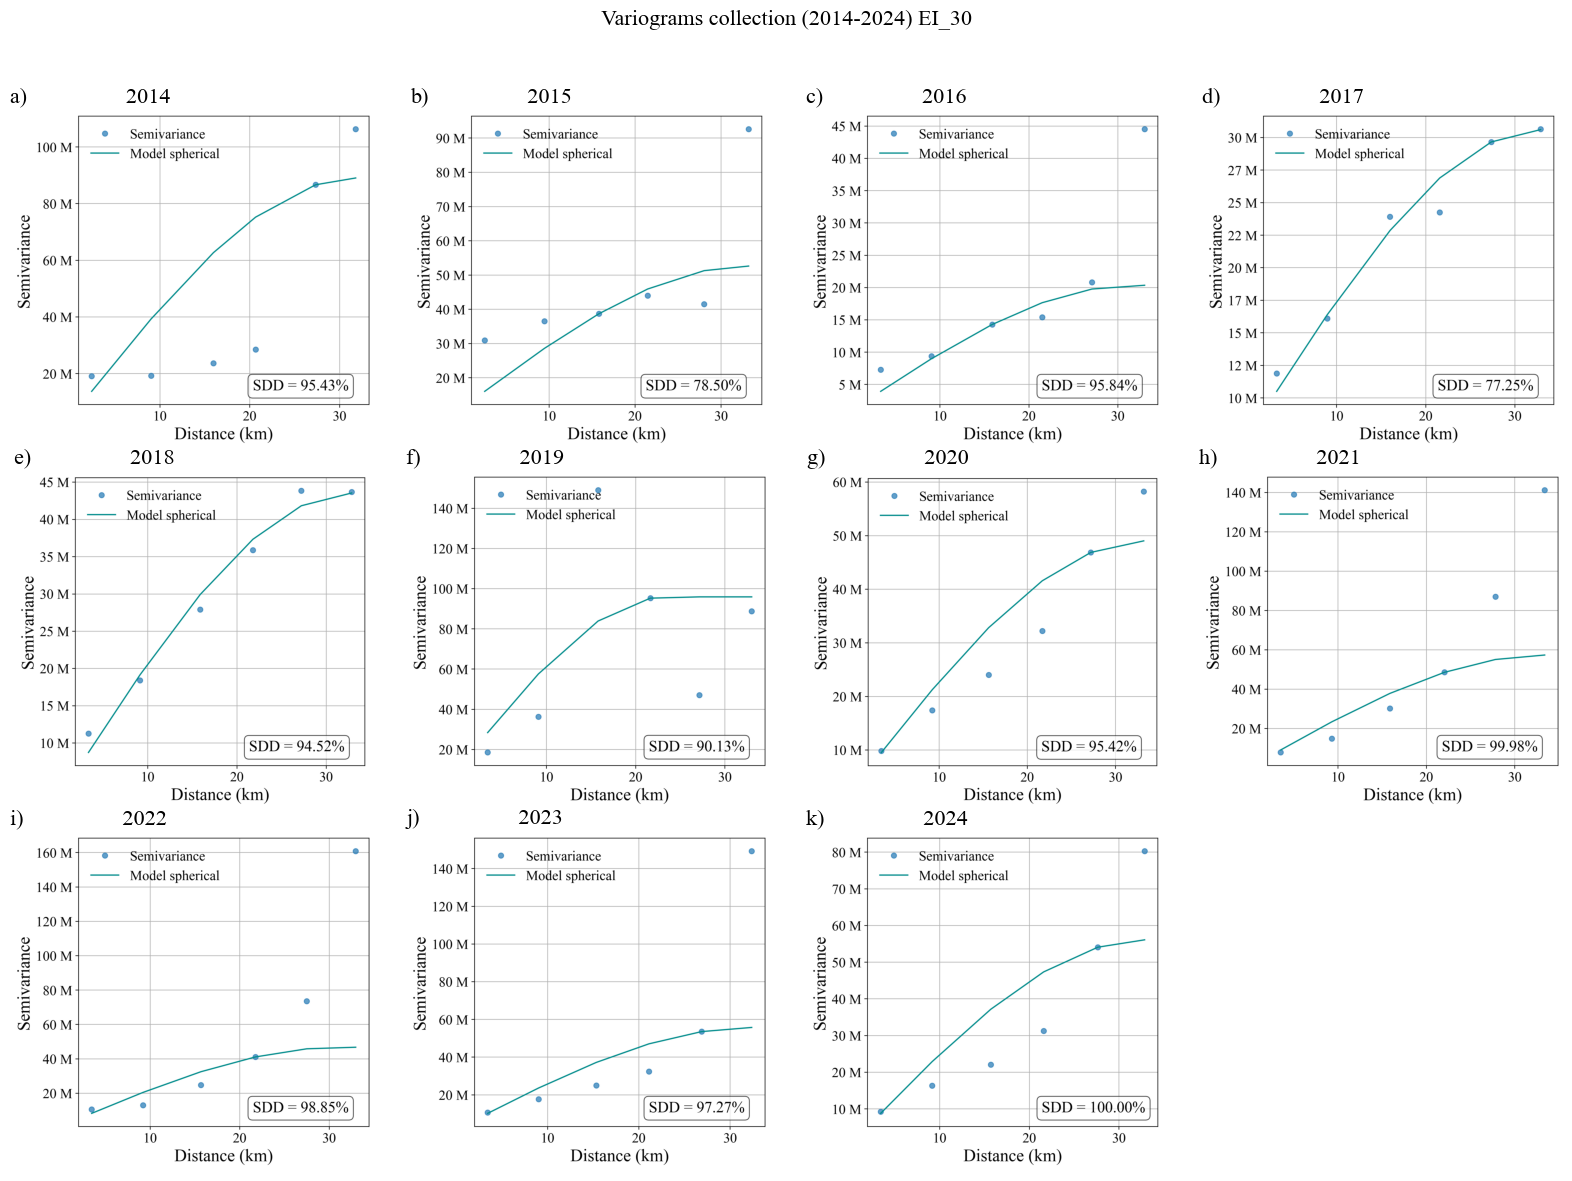

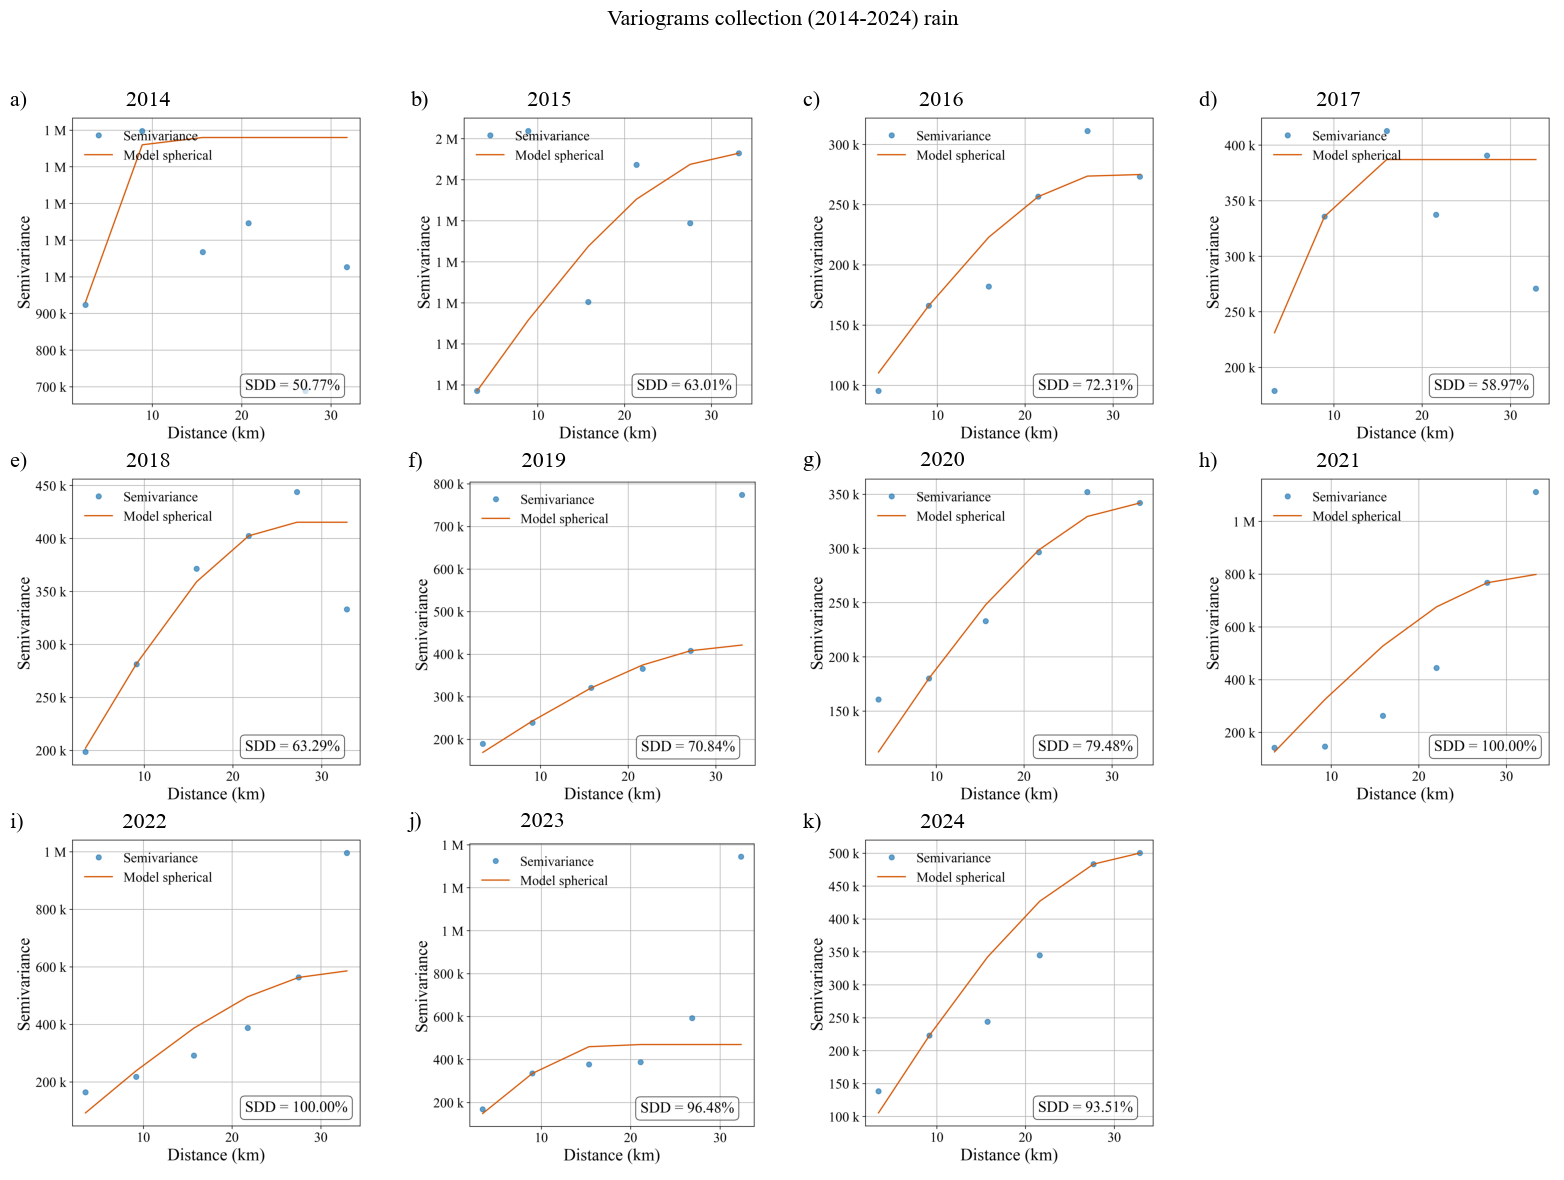

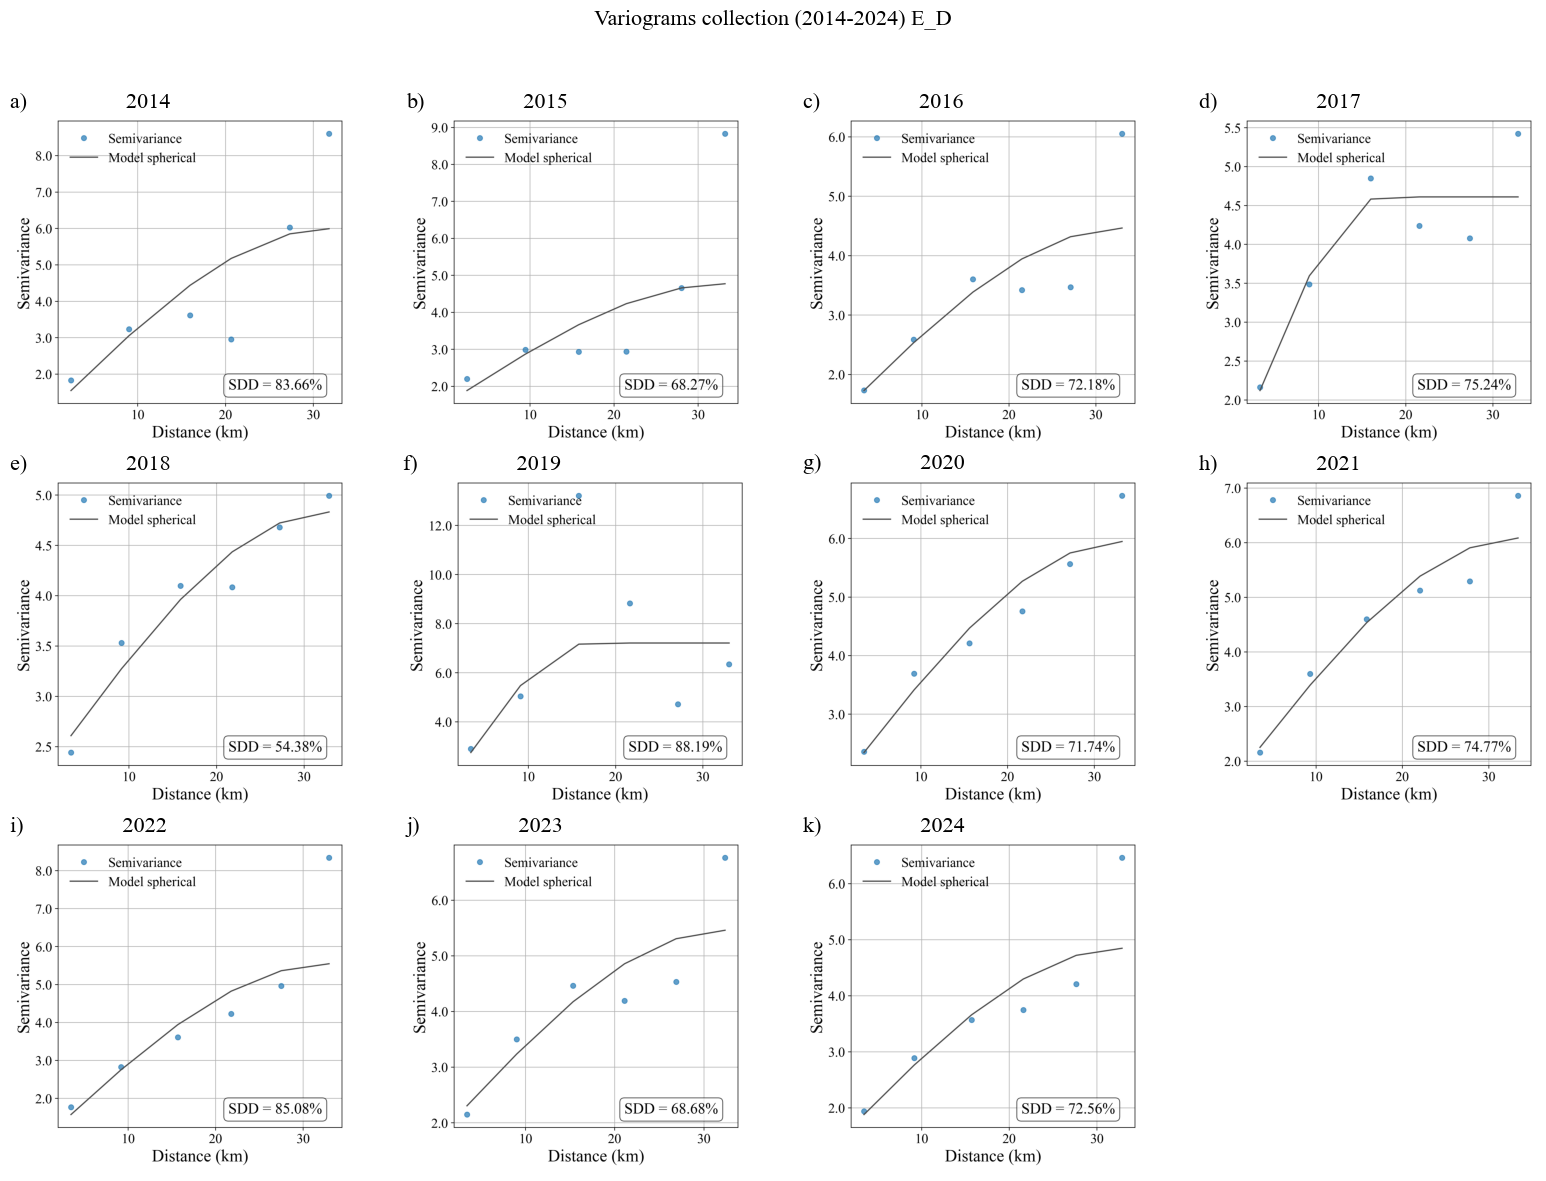

In [12]:
## VARIOGRAM COLLECTION
for mapa in mapas:
    # Configurações do diretório de entrada e anos
    input_dir = os.path.join(general_path, '2 - Result_images','presentation')
      # Anos de 2014 a 2023
    years = list(range(2014, 2025))
    # Criar o subplot
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))  
    axes = axes.flatten()  # Transformar em uma lista para iterar facilmente
    
    for i, year in enumerate(years):
        ax = axes[i]
        file_path = os.path.join(input_dir, str(year), f"Variogram_{year}_{mapa}.png")
        
        if os.path.exists(file_path):
            img = Image.open(file_path)
            ax.imshow(img)
            ax.set_title(f"{letra[i]})                  {year}", fontsize=16,loc='left')
            ax.axis('off')  # Esconder os eixos
        else:
            ax.set_title(f"{year} (Faltando)", fontsize=12, color='red')
            ax.axis('off')
    for ax in axes[len(years):]:
        fig.delaxes(ax)
    # Ajustar o layout
    fig.suptitle(f"Variograms collection (2014-2024) {mapa}", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    
    # Salvar e exibir o gráfico
    output_path_comparison = os.path.join(input_dir, f"Comparacao_Variogramas_{mapa}_2014_2024.png")
    plt.savefig(output_path_comparison, dpi=300, bbox_inches='tight')
    plt.show()

In [14]:
plt.rcParams.update({'font.family': 'Times New Roman'})
for k, mapa in enumerate(mapas):

    bounds = brasil_shapefile.total_bounds
    minx, miny, maxx, maxy = bounds
    extent = [minx, maxx, miny, maxy]
    gridx = np.linspace(minx, maxx, 150)
    gridy = np.linspace(miny, maxy, 150)
    z_min, z_max = float('inf'), float('-inf')
    cmap = cmap_list[k]
    nrows, ncols = 3, 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12), constrained_layout=True)

    # Processing the years
    for i, year in enumerate(years):

        df_data = pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='EI_30')
        df_data = df_data[['state', 'gauge_code', 'long', 'lat', str(year)]].replace(0, np.nan).dropna().reset_index(drop=True)
        df_data = df_data.rename(columns={str(year): 'EI_30'})
        df_data['E_D'] = pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='E_D')[[str(year)]].replace(0, np.nan).dropna().reset_index(drop=True)[str(year)]
        df_data['rain'] = df_data['EI_30'] / df_data['E_D']
    
        df_outliers = pd.read_hdf(os.path.join(general_path, '2 - Result_images', 'outliers_removidos.h5'), key=str(year))
        lista_outliers = df_outliers['gauge_code'].to_list()
        df_data = df_data[~df_data['gauge_code'].isin(lista_outliers)]
    
        latitude = df_data['lat'].values
        longitude = df_data['long'].values
        aqi_value = df_data[mapa].values

        output_dir = os.path.join(general_path, '2 - Result_images', 'Results-dissertação', str(year))
        if mapa == 'rain': output_dir = os.path.join(general_path, '2 - Result_images', str(year))
        raster_path = os.path.join(output_dir, f"{mapa}_map_{year}.tif")
        with rasterio.open(raster_path) as f:
            z_interp = f.read(1)

        if mapa == 'EI_30':
            z_interp = np.where(z_interp > 31000, 31000, z_interp)  # Set the maximum limit
        if mapa == 'rain':
            z_interp = np.where(z_interp > 3500, 3500, z_interp)  # Set the maximum limit

        z_min = min(z_min, z_interp.min())
        z_max = max(z_max, z_interp.max())

        ax = axes[i // ncols, i % ncols]
        im = ax.imshow(z_interp, extent=extent, origin='lower', cmap=cmap, alpha=1, vmin=None, vmax=None)
        brasil_shapefile.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)
        ax.scatter(longitude, latitude, color="k", zorder=3, marker='o', s=4)
        ax.set_title(f"{letra[i]})  {year}", fontsize=20)
        ax.set_xlim([minx, maxx])
        ax.set_ylim([miny, maxy])
        ax.grid(color='gray', linestyle='--', linewidth=0.5)
        ax.set_aspect('equal', 'box')
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1)
        ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)  # Remove border numbers

    for ax in axes.flat:
        im.set_clim(z_min, z_max)
    axes[-1, -1].axis("off")
    pos = axes[-1, -1].get_position()  # Position of the last subplot
    cbar_ax = fig.add_axes([pos.x0+0.1, pos.y0, 0.03 , pos.height-0.03])  # Uses the same position and size
    norm = cm.colors.Normalize(vmin=z_min, vmax=z_max)
    cbar = Colorbar(ax=cbar_ax, mappable=cm.ScalarMappable(norm=norm, cmap=cmap), orientation='vertical')
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label(unity[k], fontsize=18)
    plt.savefig(general_path + r'\2 - Result_images\presentation\Krigagem_ordinária_'+mapa+'_All_years', dpi=300, bbox_inches='tight')
    plt.close()


In [24]:
cmap_list = ['coolwarm', 'RdYlBu', 'viridis_r']

In [29]:
mapa='EI_30'
k=0

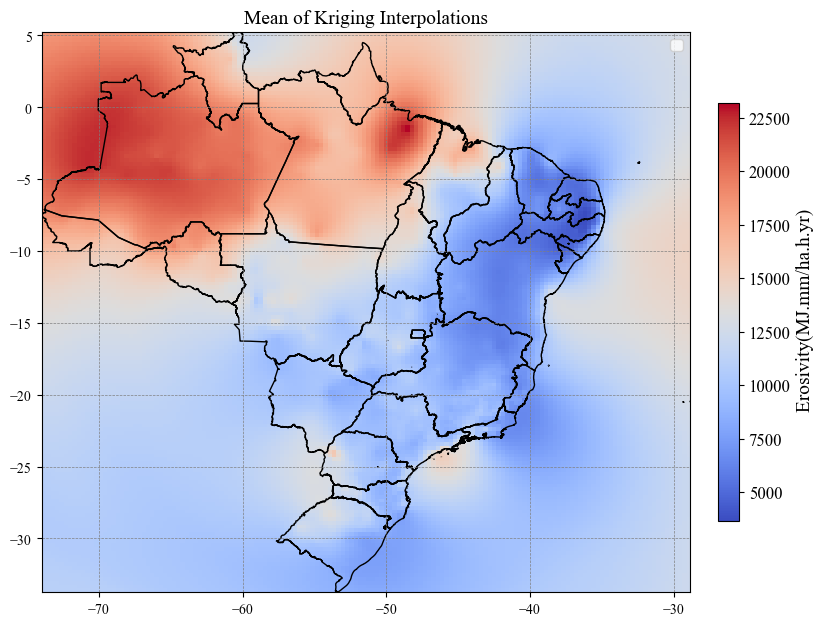

In [31]:
#DEFINIR BASE DE DADOS PARA COMPARAÇÃO - CROSS VALIDATION
df_results_subs=pd.read_hdf(general_path +'/Results_Erosivity_filled.h5',key=mapa) # FILLED
df_results_subs=df_results_subs[df_results_subs['sum']>=8] #anos de dados
columns = [str(year) for year in range(2014, 2025)]

df_results_subs['mean'] = df_results_subs[columns].apply(lambda row: row[row != 0].mean(), axis=1)  

cmap = cmap_list[k]  
# Open raster image  
output_raster_path = os.path.join(general_path, '2 - Result_images', f'{mapa}_mean_2014_2024.tif')  
with rasterio.open(output_raster_path) as src:  
    image = src.read(1)  
bounds = brasil_shapefile.total_bounds  # [minx, miny, maxx, maxy]  
minx, miny, maxx, maxy = bounds  
extent = [minx, maxx, miny, maxy]  

# Creating the main map  
fig, ax = plt.subplots(figsize=(9, 9))  
ax.imshow(image, extent=extent, origin='lower', cmap=cmap)  
brasil_shapefile.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)  
ax.grid(color='gray', linestyle='--', linewidth=0.5)  
ax.set_title(f"Mean of Kriging Interpolations", fontsize=14)  
norm = plt.Normalize(vmin=values.min(), vmax=values.max())  # Normalize  
img_plot = ax.imshow(image, extent=extent, origin='lower', cmap=cmap)  
cbar = plt.colorbar(img_plot, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)  
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(f" {unity[k]}", fontsize=14)  
ax.legend(fontsize=11)   
plt.savefig(os.path.join(general_path, '2 - Result_images','presentation', f'INV_map__{mapa}.png'), dpi=300, bbox_inches='tight')  
plt.show()

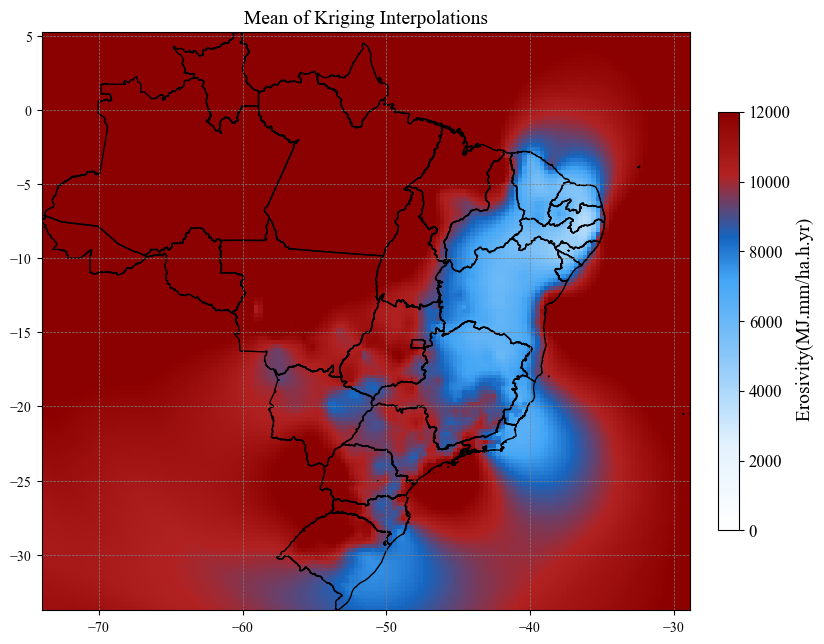

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
import geopandas as gpd
import matplotlib.colors as colors

# Definir base de dados para comparação - Cross Validation
df_results_subs = pd.read_hdf(general_path + '/Results_Erosivity_filled.h5', key=mapa)  # FILLED
df_results_subs = df_results_subs[df_results_subs['sum'] >= 8]  # anos de dados
columns = [str(year) for year in range(2014, 2025)]

df_results_subs['mean'] = df_results_subs[columns].apply(lambda row: row[row != 0].mean(), axis=1)  

# Abrir imagem raster
output_raster_path = os.path.join(general_path, '2 - Result_images', f'{mapa}_mean_2014_2024.tif')  
with rasterio.open(output_raster_path) as src:  
    image = src.read(1)  

# Definir os limites do mapa
bounds = brasil_shapefile.total_bounds  # [minx, miny, maxx, maxy]  
minx, miny, maxx, maxy = bounds  
extent = [minx, maxx, miny, maxy]  

import matplotlib.colors as mcolors

# Definir cores e seus pontos de transição (0 a 1)
colors = {
    0.0: "#FFFFFF",  # Branco (0)
    0.2: "#E3F2FD",  # Azul muito claro (2000)
    0.4: "#90CAF9",  # Azul claro (4000)
    0.6: "#42A5F5",  # Azul médio (6000)
    0.7: "#1565C0",  # Azul escuro (8000)
    0.85: "#B22222", # Vermelho médio (10000)
    1.0: "#8B0000",  # Vermelho escuro (12000+)
}

# Criar colormap suave
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", list(colors.items()))

# Criar normalização para os limites
norm = mcolors.Normalize(vmin=0, vmax=12000)

# Criar o mapa
fig, ax = plt.subplots(figsize=(9, 9))  
img_plot = ax.imshow(image, extent=extent, origin='lower', cmap=cmap, norm=norm)  
brasil_shapefile.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)  
ax.grid(color='gray', linestyle='--', linewidth=0.5)  
ax.set_title("Mean of Kriging Interpolations", fontsize=14)  

# Adicionar barra de cores
cbar = plt.colorbar(img_plot, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)  
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(f" {unity[k]}", fontsize=14)  

plt.savefig(os.path.join(general_path, '2 - Result_images', 'presentation', f'INV_map_ii_{mapa}.png'), dpi=300, bbox_inches='tight')  
plt.show()


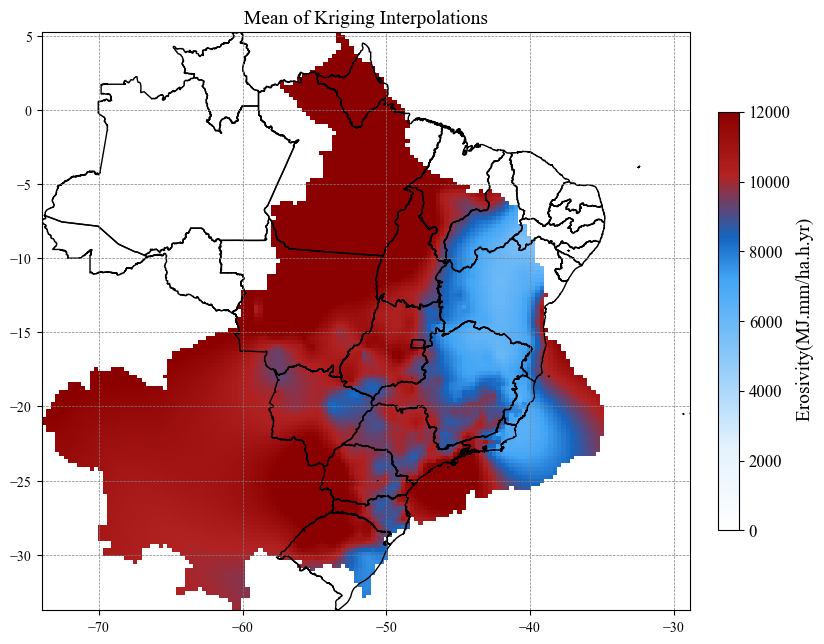

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio
import os
import geopandas as gpd
import matplotlib.colors as mcolors
from rasterio.mask import mask
from shapely.geometry import mapping

# Definir base de dados para comparação - Cross Validation
df_results_subs = pd.read_hdf(general_path + '/Results_Erosivity_filled.h5', key=mapa)  # FILLED
df_results_subs = df_results_subs[df_results_subs['sum'] >= 8]  # Anos de dados
columns = [str(year) for year in range(2014, 2025)]
df_results_subs['mean'] = df_results_subs[columns].apply(lambda row: row[row != 0].mean(), axis=1)  

# Abrir imagem raster
output_raster_path = os.path.join(general_path, '2 - Result_images', f'{mapa}_mean_2014_2024.tif')  
with rasterio.open(output_raster_path) as src:  
    raster_crs = src.crs  # CRS do raster
    brasil_shapefile = brasil_shapefile.to_crs(raster_crs)  # Converter CRS do shapefile para o do raster
    
    # Recortar o raster usando o shapefile
    shapes = [mapping(geom) for geom in brasil_shapefile.geometry]  # Converter para formato compatível
    image, transform = mask(src.read(1)[::-1, :], shapes, crop=True)  # Aplicar máscara
    
    # Pegar apenas a primeira banda
    image = image[0]






# Ajustar os limites do raster recortado
minx, miny, maxx, maxy = brasil_shapefile.total_bounds  
extent = [minx, maxx, miny, maxy]  

colors = {
    0.0: "#FFFFFF",  # Branco (0)
    0.2: "#E3F2FD",  # Azul muito claro (2000)
    0.4: "#90CAF9",  # Azul claro (4000)
    0.6: "#42A5F5",  # Azul médio (6000)
    0.7: "#1565C0",  # Azul escuro (8000)
    0.85: "#B22222", # Vermelho médio (10000)
    1.0: "#8B0000",  # Vermelho escuro (12000+)
}

# Criar colormap suave
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", list(colors.items()))

# Criar normalização para os limites
norm = mcolors.Normalize(vmin=0, vmax=12000)

# Criar o mapa
fig, ax = plt.subplots(figsize=(9, 9))  
img_plot = ax.imshow(image, extent=extent, origin='lower', cmap=cmap, norm=norm)  
brasil_shapefile.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)  
ax.grid(color='gray', linestyle='--', linewidth=0.5)  
ax.set_title("Mean of Kriging Interpolations", fontsize=14)  

# Adicionar barra de cores
cbar = plt.colorbar(img_plot, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)  
cbar.ax.tick_params(labelsize=12)  
cbar.set_label(f" {unity[k]}", fontsize=14)  

plt.savefig(os.path.join(general_path, '2 - Result_images', 'presentation', f'INV_map_i_{mapa}.png'), dpi=300, bbox_inches='tight')  
plt.show()


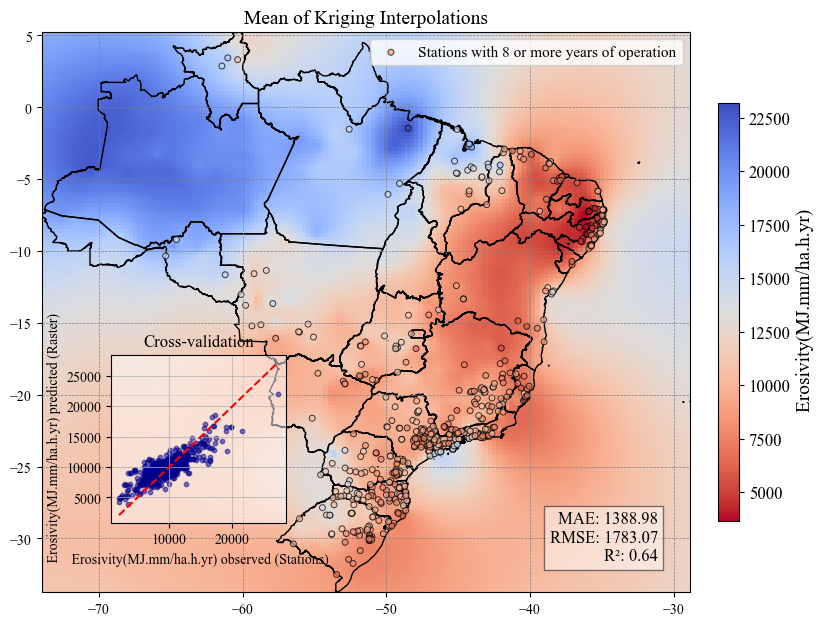

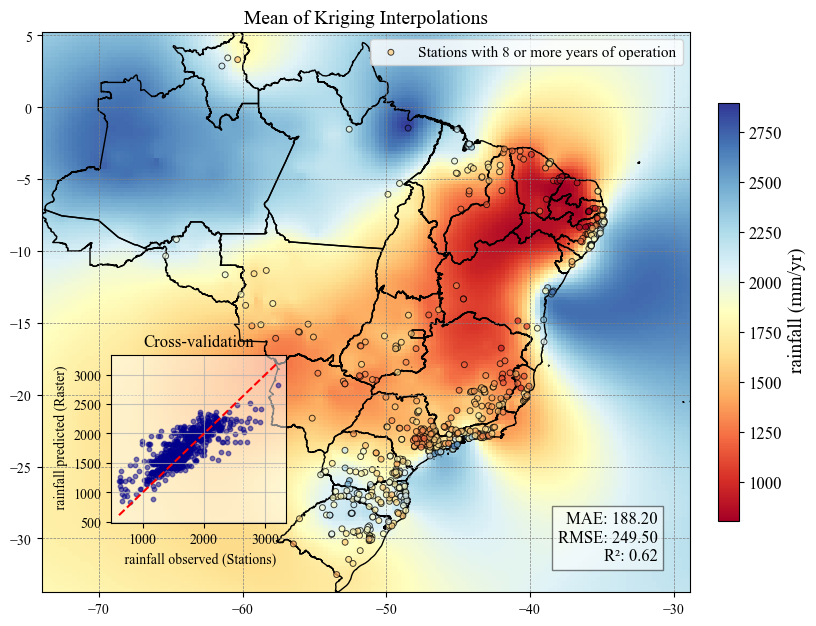

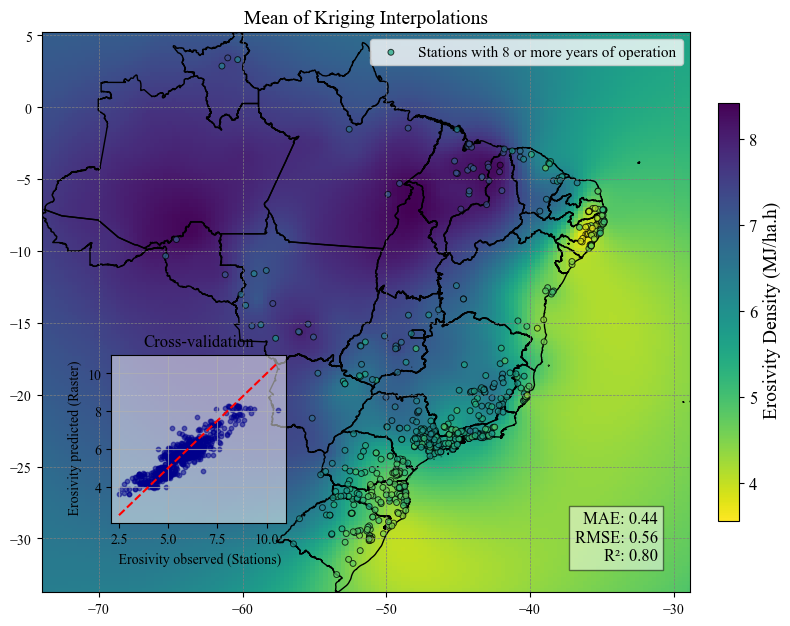

In [20]:
plt.rcParams.update({'font.family': 'Times New Roman'})


for k, mapa in enumerate(mapas):
    #DEFINIR BASE DE DADOS PARA COMPARAÇÃO - CROSS VALIDATION
    df_results_subs=pd.read_hdf(general_path +'/Results_Erosivity_filled.h5',key=mapa) # FILLED
    df_results_subs=df_results_subs[df_results_subs['sum']>=8] #anos de dados
    columns = [str(year) for year in range(2014, 2025)]

    df_results_subs['mean'] = df_results_subs[columns].apply(lambda row: row[row != 0].mean(), axis=1)  
    
    cmap = cmap_list[k]  
    # Open raster image  
    output_raster_path = os.path.join(general_path, '2 - Result_images', f'{mapa}_mean_2014_2024.tif')  
    with rasterio.open(output_raster_path) as src:  
        image = src.read(1)  
    bounds = brasil_shapefile.total_bounds  # [minx, miny, maxx, maxy]  
    minx, miny, maxx, maxy = bounds  
    extent = [minx, maxx, miny, maxy]  
    
    point_values = []  
    for _, row in df_results_subs.iterrows():  
        lon, lat = row['long'], row['lat']  
        y = math.ceil((lat + 33.75) * 150 / 39)  
        x = math.ceil((lon + 74) * 150 / 45.2)  
        point_values.append(image[y, x])  
    
    mae = mean_absolute_error(df_results_subs['mean'], point_values)  
    rmse = mean_squared_error(df_results_subs['mean'], point_values, squared=False)  
    r2 = r2_score(df_results_subs['mean'], point_values)  
    values = df_results_subs['mean']  
    
    # Creating the main map  
    fig, ax = plt.subplots(figsize=(9, 9))  
    ax.imshow(image, extent=extent, origin='lower', cmap=cmap)  
    brasil_shapefile.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)  
    ax.grid(color='gray', linestyle='--', linewidth=0.5)  
    ax.set_title(f"Mean of Kriging Interpolations", fontsize=14)  
    norm = plt.Normalize(vmin=values.min(), vmax=values.max())  # Normalize  
    scatter = ax.scatter(df_results_subs['long'], df_results_subs['lat'], c=values, cmap=cmap, s=18,  
                         edgecolor='black', linewidth=0.7, label='Stations with 8 or more years of operation', alpha=0.75)  
    
    img_plot = ax.imshow(image, extent=extent, origin='lower', cmap=cmap)  
    cbar = plt.colorbar(img_plot, ax=ax, orientation='vertical', fraction=0.03, pad=0.04)  
    cbar.ax.tick_params(labelsize=12)  
    cbar.set_label(f" {unity[k]}", fontsize=14)  
    ax.legend(fontsize=11)  
    
    # Adding the text box in the lower right corner  
    stats_text = f"MAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.2f}"  
    ax.text(0.95, 0.05, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='bottom',  
            horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.5))  
    
    # Adding the cross-validation plot in the lower left corner  
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes  
    
    inset_ax = inset_axes(ax, width="27%", height="30%", loc='lower left', borderpad=5)  
    inset_ax.scatter(df_results_subs['mean'], point_values, s=10, color='darkblue', alpha=0.5)  
    inset_ax.plot([min(df_results_subs['mean']), max(df_results_subs['mean'])],  
                  [min(df_results_subs['mean']), max(df_results_subs['mean'])], color='red', linestyle='--')  
    inset_ax.set_title("Cross-validation", fontsize=12)  
    inset_ax.set_xlabel(f" {unity[k].split(' ')[0]} observed (Stations)", fontsize=10)  
    inset_ax.set_ylabel(f" {unity[k].split(' ')[0]} predicted (Raster)", fontsize=10)  
    inset_ax.tick_params(axis='both', which='major', labelsize=10)  
    inset_ax.grid(True, alpha=0.7)  
    inset_ax.patch.set_alpha(0.5)  # Transparent background for the plot  
    
    # Saving and displaying  
    plt.savefig(os.path.join(general_path, '2 - Result_images','presentation', f'map_EVALUATION_{mapa}.png'), dpi=300, bbox_inches='tight')  
    plt.show()


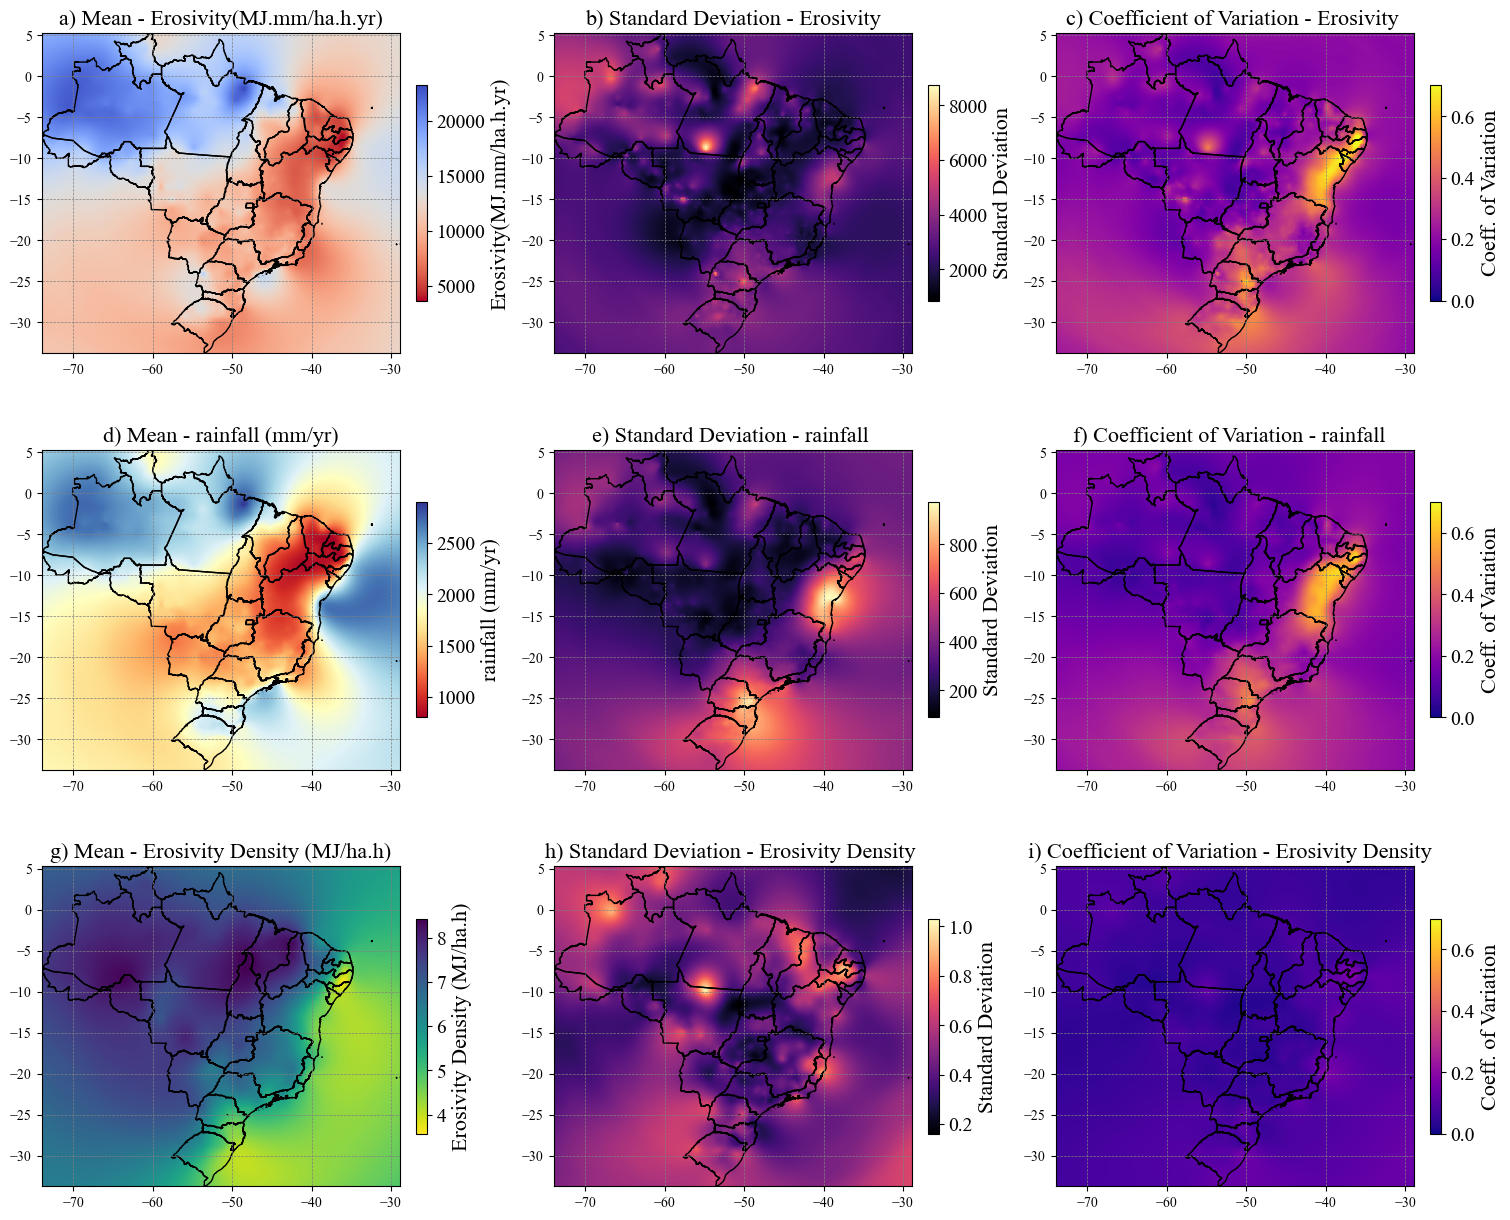

In [22]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12.5), constrained_layout=True)
for i, mapa in enumerate(mapas):
    output_std_dev_path = os.path.join(general_path, '2 - Result_images', f'{mapa}_std_dev_2014_2024.tif')
    output_mean_path = os.path.join(general_path, '2 - Result_images', f'{mapa}_mean_2014_2024.tif')
    
    with rasterio.open(output_mean_path) as src_mean, rasterio.open(output_std_dev_path) as src_std:
        image_mean = src_mean.read(1)
        image_std = src_std.read(1)
        image_c_v = image_std / image_mean
    bounds = brasil_shapefile.total_bounds  
    minx, miny, maxx, maxy = bounds  
    extent = [minx, maxx, miny, maxy]  
    
    # Assigning subplots for each row  
    ax_mean, ax_std, ax_cv = axes.flatten()[i * 3:i * 3 + 3]  
    
    # Mean map  
    img_plot_mean = ax_mean.imshow(image_mean, extent=extent, origin='lower', cmap=cmap_list[i])  
    brasil_shapefile.plot(ax=ax_mean, facecolor="none", edgecolor="black", linewidth=1)  
    ax_mean.set_title(f'{letra[i * 3]}) Mean - {unity[i]}', fontsize=16)  
    ax_mean.grid(color='gray', linestyle='--', linewidth=0.5)  
    cbar_mean = plt.colorbar(img_plot_mean, ax=ax_mean, orientation='vertical', fraction=0.03, pad=0.04)  
    cbar_mean.ax.tick_params(labelsize=14)  
    cbar_mean.set_label(f'{unity[i]}', fontsize=16)  
    
    # Standard deviation map  
    img_plot_std = ax_std.imshow(image_std, extent=extent, origin='lower', cmap='magma')  
    brasil_shapefile.plot(ax=ax_std, facecolor="none", edgecolor="black", linewidth=1)  
    ax_std.set_title(f'{letra[i * 3 + 1]}) Standard Deviation - {unity[i].split("(")[0]}', fontsize=16)  
    ax_std.grid(color='gray', linestyle='--', linewidth=0.5)  
    cbar_std = plt.colorbar(img_plot_std, ax=ax_std, orientation='vertical', fraction=0.03, pad=0.04)  
    cbar_std.ax.tick_params(labelsize=14)  
    cbar_std.set_label('Standard Deviation', fontsize=16)  
    
    # Coefficient of variation map  
    img_plot_cv = ax_cv.imshow(image_c_v, extent=extent, origin='lower', cmap='plasma', vmin=0, vmax=0.7)  
    brasil_shapefile.plot(ax=ax_cv, facecolor="none", edgecolor="black", linewidth=1)  
    ax_cv.set_title(f'{letra[i * 3 + 2]}) Coefficient of Variation - {unity[i].split("(")[0]} ', fontsize=16)  
    ax_cv.grid(color='gray', linestyle='--', linewidth=0.5)  
    cbar_cv = plt.colorbar(img_plot_cv, ax=ax_cv, orientation='vertical', fraction=0.03, pad=0.04)  
    cbar_cv.ax.tick_params(labelsize=14)  
    cbar_cv.set_label('Coeff. of Variation', fontsize=16)  

# Salvar e exibir o gráfico
plt.savefig(os.path.join(general_path, '2 - Result_images','presentation', 'map_Media_Desvio.png'), dpi=300, bbox_inches='tight')
plt.show()


In [23]:

# Extract the necessary columns
latitude = df_data['lat'].values
longitude = df_data['long'].values
aqi_value = df_data[str(year)].values
# Define the grid for interpolation
bounds = brasil_shapefile.total_bounds  # [minx, miny, maxx, maxy]
minx, miny, maxx, maxy = bounds
gridx = np.linspace(minx , maxx , 150)
gridy = np.linspace(miny, maxy , 150)

## Ordinary Kriging

Plotting Enabled

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'spherical' Variogram Model
Partial Sill: 71943707.99522984
Full Sill: 114103833.90526006
Range: 7.609283067277492
Nugget: 42160125.91003021 



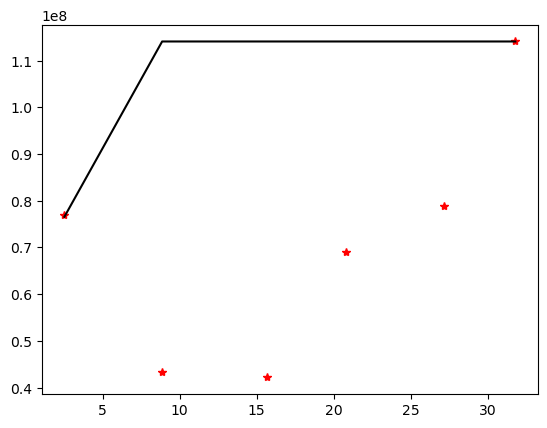

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [24]:


# Perform Ordinary Kriging using the spherical variogram model
OK = OrdinaryKriging(longitude, 
                     latitude, 
                     aqi_value, 
                     variogram_model='spherical', 
                     coordinates_type='geographic', 
                     verbose=True, 
                     enable_plotting=True)
z_interp, ss = OK.execute('grid', gridx, gridy)

## Create overlay image of kriging interpolated values

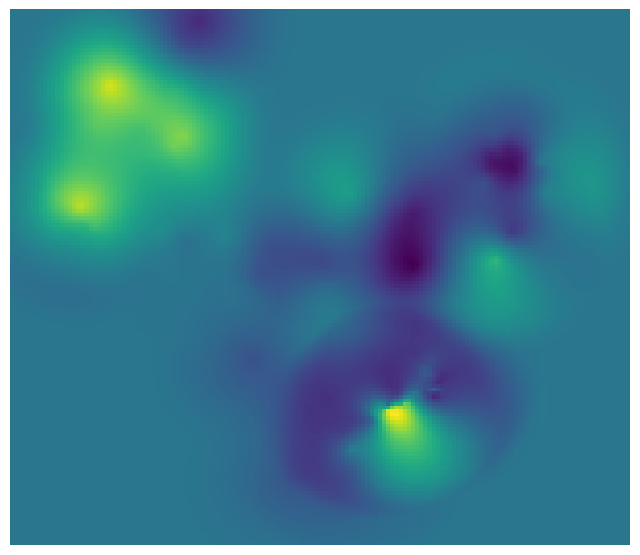

In [25]:
year = 2014
df_data = pd.read_hdf(f"{general_path}/Results_Erosivity_zero.h5", key='EI_30')
df_data=df_data[['long','lat',str(year),'state','gauge_code']].replace(0, np.nan).dropna().reset_index(drop=True)
df_data
latitude = df_data['lat'].values
longitude = df_data['long'].values
aqi_value = df_data[str(year)].values

# Perform Ordinary Kriging using the spherical variogram model
OK = OrdinaryKriging(longitude, 
                     latitude, 
                     aqi_value, 
                     variogram_model='spherical', 
                     coordinates_type='geographic', 
                     verbose=True, 
                     enable_plotting=True)
z_interp, ss = OK.execute('grid', gridx, gridy)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Plot the interpolation results
cax = ax.imshow(z_interp, 
                extent=[gridx.min(), 
                        gridx.max(), 
                        gridy.min(), 
                        gridy.max()], 
                origin='lower', 
                cmap='viridis', 
                alpha=1)
ax.axis('off')

# Save the image
fig.savefig('kriging_interpolation.png', bbox_inches='tight', pad_inches=0, transparent=True)
plt.close(fig)

# Load the image with PIL
image = Image.open('kriging_interpolation.png')
fig          

## Create base map with overlayed interpolated data

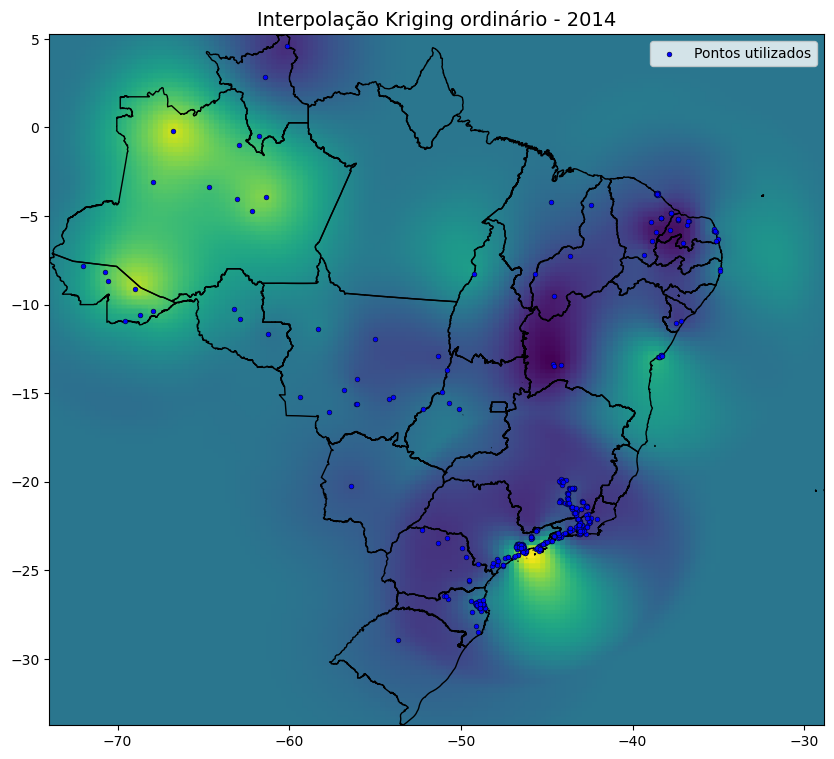

In [29]:



# Abrir a imagem interpolada recortada
image_path = "kriging_interpolation.png"
image = Image.open(image_path)

# Configurar os limites do recorte na escala geográfica
bounds = brasil_shapefile.total_bounds  # [minx, miny, maxx, maxy]
minx, miny, maxx, maxy = bounds
extent = [minx, maxx, miny, maxy]  # Extensão da área de interesse

# Criar a figura e os eixos
fig, ax = plt.subplots(figsize=(10, 10))

# Exibir a imagem interpolada como plano de fundo
ax.imshow(image, extent=extent, origin='upper', cmap='viridis')

# Plotar o shapefile do Brasil
brasil_shapefile.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)

# Plotar os pontos utilizados
ax.scatter(longitude, latitude, color="blue", label="Pontos utilizados", zorder=3,marker='o',s=12,edgecolor="black",linewidth=0.35 )


# Configurar título e legenda
ax.set_title(f"Interpolação Kriging ordinário - {}", fontsize=14)
ax.legend()

# Salvar a figura
plt.savefig(f"Kriging_map_{year}.png", dpi=300, bbox_inches='tight')

# Mostrar a figura
plt.show()

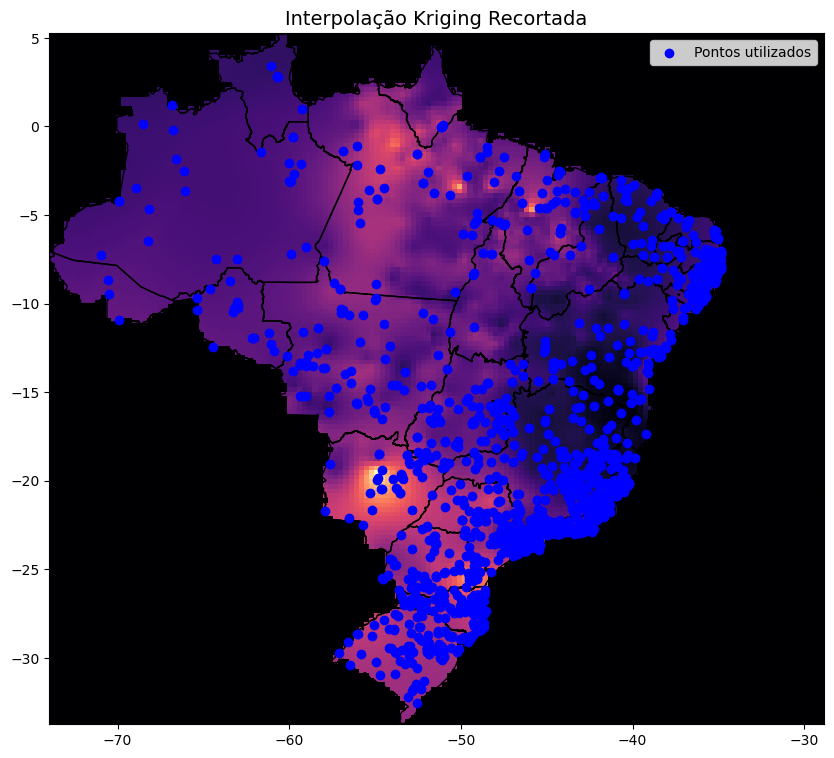

In [39]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from PIL import Image

# Salvar a interpolação como um GeoTIFF
with rasterio.open(
    "interpolation.tif",
    "w",
    driver="GTiff",
    height=z_interp.shape[0],
    width=z_interp.shape[1],
    count=1,
    dtype=z_interp.dtype,
    crs="EPSG:4326",  # Certifique-se de usar a projeção correta
    transform=rasterio.transform.from_bounds(minx, miny, maxx, maxy, z_interp.shape[1], z_interp.shape[0]),
) as dst:
    dst.write(z_interp, 1)


# Recortar o GeoTIFF com base no shapefile
with rasterio.open("interpolation.tif") as src:
    out_image, out_transform = mask(src, brasil_shapefile.geometry, crop=True)
    out_meta = src.meta

# Atualizar metadados para o novo arquivo recortado
out_meta.update(
    {"driver": "GTiff", "height": out_image.shape[1], "width": out_image.shape[2], "transform": out_transform}
)

# Salvar o GeoTIFF recortado
with rasterio.open("interpolation_cropped.tif", "w", **out_meta) as dest:
    dest.write(out_image)

# Reabrir e plotar a imagem recortada
with rasterio.open("interpolation_cropped.tif") as src:
    image_cropped = src.read(1)
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image_cropped, extent=extent, origin="upper", cmap="magma")
brasil_shapefile.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1)
ax.scatter(longitude, latitude, color="blue", label="Pontos utilizados", zorder=3, marker="o")
ax.set_title("Interpolação Kriging Recortada", fontsize=14)
ax.legend()
plt.show()



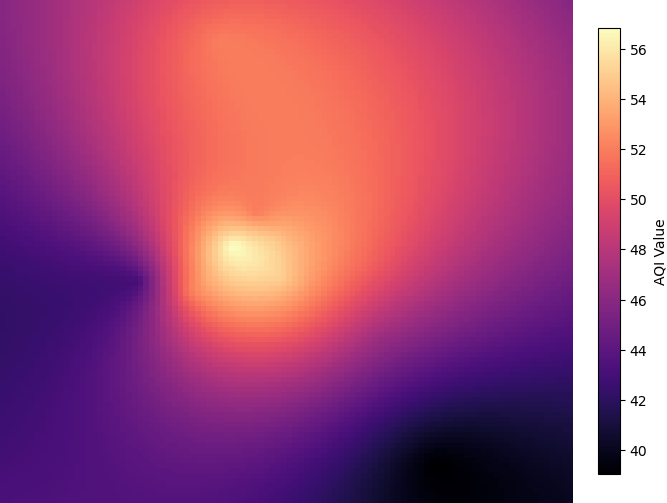

In [15]:
import folium
from folium.raster_layers import ImageOverlay

# Create a base map centered on Houston
m = folium.Map(location=[29.76, -95.37], zoom_start=10)

# Define the bounds where the image will be placed
bounds = [[gridy.min(), gridx.min()], [gridy.max(), gridx.max()]]

# Add the image overlay
image_overlay = ImageOverlay(
    image='kriging_interpolation.png',
    bounds=bounds,
    opacity=.7,
    interactive=True,
    cross_origin=False,
    zindex=1,
)

image_overlay.add_to(m)

# Add points for the measuring stations
for lat, lon in zip(latitude, longitude):
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=1
    ).add_to(m)

# Save the map to an HTML file
m.save('houston_kriging_map_with_mesh.html')

# Display the map
m
